INITIALISATION AND PRE - PROCESSING

Downloading and Cleaning Defence Firm and Market Index Data

In [3]:
#Import initial libraries
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt

In [4]:
# Define Event Dates
event_dates = {
    "gfc": "2008-09-15",
    "eurocrisis": "2010-05-06",
    "china_crash": "2015-06-12",
    "covid": "2020-03-11",
    "ukraine": "2022-02-24"
}

# Event window: 100 days
window_size = 100

In [5]:
# Define Tickers
tickers = {
    'UK': ['BA.L', 'RYCEY', 'BAB.L', 'SRP.L', 'CHG.L', 'QQ.L', '^FTSE'],
    'Germany': ['RHM.DE', 'TKA.DE', '^GDAXI'],
    'Sweden': ['SAAB-B.ST', 'EWD'],
    'France': ['HO.PA', 'SAF.PA', 'AM.PA', '^FCHI'],
    'USA': ['BA', 'RTX', 'LMT', 'NOC', 'GD', 'LHX', 'HON', 'CACI', 'GE', 'TXT', 'TDY', 'OSK', 'ETN', 'CW', '^GSPC'],
    'Korea': ['000880.KS', '^KS11'],
    'Japan': ['7011.T', '7013.T', '6701.T', '^N225'],
    'China': ['000768.SZ', '600879.SS', '000065.SZ', '600118.SS', '600850.SS', '600150.SS', '600893.SS', '000001.SS']
}

In [6]:
# Country to index ticker mapping for CAPM
market_index_tickers = {
    'US': '^GSPC',
    'UK': '^FTSE',
    'Germany': '^GDAXI',
    'France': '^FCHI',
    'Japan': '^N225',
    'Korea': '^KS11',
    'Sweden': 'EWD',
    'China': '000001.SS'
}

In [7]:
# Fetch/Download Data Function
def fetch_event_data(event_date, tickers, window=100):
    event_dt = pd.to_datetime(event_date)
    start = event_dt - pd.Timedelta(days=window * 2)  # Approx to cover 100 trading days, because not all calendar days are trading days
    end = event_dt + pd.Timedelta(days=window * 2)
    data = yf.download(tickers=sum(tickers.values(), []), start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'))
    return data['Close']

In [8]:
# Downloading Data
gfc_data = fetch_event_data(event_dates['gfc'], tickers)
eurocrisis_data = fetch_event_data(event_dates['eurocrisis'], tickers)
china_crash_data = fetch_event_data(event_dates['china_crash'], tickers)
covid_data = fetch_event_data(event_dates['covid'], tickers)
ukraine_data = fetch_event_data(event_dates['ukraine'], tickers)

C:\Users\pauln\AppData\Local\Temp\ipykernel_15752\1122728340.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers=sum(tickers.values(), []), start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'))
[*********************100%***********************]  45 of 45 completed
C:\Users\pauln\AppData\Local\Temp\ipykernel_15752\1122728340.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers=sum(tickers.values(), []), start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'))
[*********************100%***********************]  45 of 45 completed
C:\Users\pauln\AppData\Local\Temp\ipykernel_15752\1122728340.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers=sum(tickers.values(), []), start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'))
[*********************100%***********************]  45 of 45 co

In [9]:
# Clean and Analyze Function
def clean_and_analyze_event_data(event_data, event_date_str):
    event_date = pd.to_datetime(event_date_str)

    # Drop rows with any NaNs
    cleaned_data = event_data.dropna()

    # Count days before and after the event
    days_before = cleaned_data[cleaned_data.index < event_date].shape[0]
    days_after = cleaned_data[cleaned_data.index > event_date].shape[0]

    print(f"Event on {event_date.date()}:")
    print(f"Trading days before event: {days_before}")
    print(f"Trading days after event: {days_after}\n")

    return cleaned_data

In [10]:
# Apply to all events
gfc_data_clean = clean_and_analyze_event_data(gfc_data, event_dates['gfc'])
eurocrisis_data_clean = clean_and_analyze_event_data(eurocrisis_data, event_dates['eurocrisis'])
china_crash_data_clean = clean_and_analyze_event_data(china_crash_data, event_dates['china_crash'])
covid_data_clean = clean_and_analyze_event_data(covid_data, event_dates['covid'])
ukraine_data_clean = clean_and_analyze_event_data(ukraine_data, event_dates['ukraine'])

Event on 2008-09-15:
Trading days before event: 122
Trading days after event: 115

Event on 2010-05-06:
Trading days before event: 117
Trading days after event: 115

Event on 2015-06-12:
Trading days before event: 116
Trading days after event: 113

Event on 2020-03-11:
Trading days before event: 107
Trading days after event: 115

Event on 2022-02-24:
Trading days before event: 110
Trading days after event: 113



Importing and Processing Risk-Free Data CSVs to (later) calculate Excess and Abnormal Returns

In [12]:
import statsmodels.api as sm
from scipy.stats import ttest_ind
import os

In [13]:
# Import risk free rate csvs
risk_free_files = {
    'US': 'US3M.csv',
    'UK': 'UK3M.csv',
    'Sweden': 'SW3M.csv',
    'China': 'CH3M.csv',
    'Germany': 'GE3M.csv',
    'France': 'FR3M.csv',
    'Japan': 'JP3M.csv',
    'Korea': 'KR3M.csv'
}

In [14]:
# Creating Market Index Returns for later calculations
market_returns = {}
start_date = '2006-01-01'
end_date = '2024-12-31'

for country, ticker in market_index_tickers.items():
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)[['Close']].dropna()
    df.columns = ['price']  # Flatten column name
    df['date'] = df.index
    df['market_return'] = np.log(df['price'] / df['price'].shift(1))
    df = df[['date', 'market_return']].dropna()
    market_returns[country] = df.reset_index(drop=True)

C:\Users\pauln\AppData\Local\Temp\ipykernel_15752\645700037.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)[['Close']].dropna()
C:\Users\pauln\AppData\Local\Temp\ipykernel_15752\645700037.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)[['Close']].dropna()
C:\Users\pauln\AppData\Local\Temp\ipykernel_15752\645700037.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)[['Close']].dropna()
C:\Users\pauln\AppData\Local\Temp\ipykernel_15752\645700037.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)[['Close']].dropna()
C:\Users\pauln\AppData\Local\Temp\ipykernel_

In [15]:
# Normalizing risk free data
risk_free_data = {}

for code, path in risk_free_files.items():
    df = pd.read_csv(path)
    
    # Normalize and print columns
    df.columns = [col.strip().lower() for col in df.columns]
    print(f"{code} columns after normalization:", df.columns.tolist())
    
    if 'date' not in df.columns or 'rate' not in df.columns:
        print(f"Skipping {code}: missing 'date' or 'rate' column")
        continue
    
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df.dropna(subset=['date', 'rate'], inplace=True)
    df['rate'] = df['rate'] / 100
    risk_free_data[code] = df

US columns after normalization: ['date', 'rate']
UK columns after normalization: ['date', 'rate']
Sweden columns after normalization: ['date', 'rate']
China columns after normalization: ['date', 'rate']
Germany columns after normalization: ['date', 'rate']
France columns after normalization: ['date', 'rate']
Japan columns after normalization: ['date', 'rate']
Korea columns after normalization: ['date', 'rate']


CALCULATING ACTUAL, EXCESS, AND CUMULATIVE ABNORMAL RETURNS

Defining Necessary Functions

In [18]:
# Log Returns
def calculate_log_returns(df):
    return np.log(df / df.shift(1)).dropna()

In [19]:
# Mapping Tickers to Countries Function
def get_country_from_ticker(ticker):
    if ticker in ['BA.L', 'RYCEY', 'BAB.L', 'SRP.L', 'CHG.L', '^FTSE']: return 'UK'
    elif ticker in ['RHM.DE', 'TKA.DE', '^GDAXI']: return 'Germany'
    elif ticker in ['SAAB-B.ST', 'EWD']: return 'Sweden'
    elif ticker in ['HO.PA', 'SAF.PA', 'AM.PA', '^FCHI']: return 'France'
    elif ticker in ['BA', 'RTX', 'LMT', 'NOC', 'GD', 'LHX', 'HON', 'CACI', 'GE', 'TXT', 'TDY', 'OSK', 'ETN', 'CW', '^GSPC']: return 'US'
    elif ticker in ['000880.KS', '^KS11']: return 'Korea'
    elif ticker in ['7011.T', '7013.T', '6701.T', '^N225']: return 'Japan'
    elif ticker in ['000768.SZ', '600879.SS', '000065.SZ', '600118.SS', '600850.SS', '600150.SS', '600893.SS', '000001.SS']: return 'China'
    else: return 'UNKNOWN'

In [20]:
# Defining Function to Process Actual, Excess, and Cumulative Abnormal Returns
def process_event_returns(event_data_clean, event_date_str, risk_free_data, market_returns):
    event_date = pd.to_datetime(event_date_str)
    log_returns = calculate_log_returns(event_data_clean)
    log_returns.index.name = 'date'

    results = []

    for ticker in log_returns.columns:
        country_code = get_country_from_ticker(ticker)
        if country_code == 'UNKNOWN':
            continue

        rf_df = risk_free_data[country_code]
        mrkt = market_returns[country_code]

        merged = log_returns[[ticker]].reset_index().merge(
            rf_df, how='left', on='date'
        ).merge(
            mrkt, how='left', on='date'
        ).dropna()

        merged['excess_return'] = merged[ticker] - merged['rate']
        merged['market_excess'] = merged['market_return'] - merged['rate']

        pre_event = merged[merged['date'] < event_date]
        if pre_event.shape[0] < 30: continue

        # CAPM Regression
        X = sm.add_constant(pre_event['market_excess'])
        y = pre_event['excess_return']
        model = sm.OLS(y, X).fit()
        alpha, beta = model.params

        # Expected return from CAPM
        merged['expected_return'] = merged['rate'] + beta * merged['market_excess']
        merged['abnormal_return'] = merged[ticker] - merged['expected_return']
        merged['CAR'] = merged['abnormal_return'].cumsum()

        merged['post_event'] = (merged['date'] >= event_date).astype(int)
        merged['event'] = event_date_str
        merged['ticker'] = ticker

        results.append(merged)

    return pd.concat(results, ignore_index=True)

Running process_event_returns on stock (Firm and Market Index) data

In [22]:
# Running Returns Function on stock (Firm and Market Index) data
event_clean_data = {
    'gfc': gfc_data_clean,
    'eurocrisis': eurocrisis_data_clean,
    'china_crash': china_crash_data_clean,
    'covid': covid_data_clean,
    'ukraine': ukraine_data_clean
}

all_event_results = []

for name, data in event_clean_data.items():
    res = process_event_returns(data, event_dates[name], risk_free_data, market_returns)
    all_event_results.append(res)

all_returns = pd.concat(all_event_results, ignore_index=True)

Creating mean pre and post event returns dataset

In [24]:
# Including Actual Returns Column
all_returns['actual_return'] = all_returns.apply(lambda row: row[row['ticker']], axis=1)

# Creating a binary pre/post column
all_returns['period'] = all_returns['post_event'].map({0: 'Pre', 1: 'Post'})

# Creating mean pre and post event metrics dataset
summary_by_company = all_returns.groupby(['event', 'ticker', 'period']).agg(
    avg_actual_return=('actual_return', 'mean'),
    avg_excess_return=('excess_return', 'mean'),
    avg_CAR=('CAR', 'mean')
).reset_index()

summary_by_company = summary_by_company[
    ['event', 'ticker', 'period', 'avg_actual_return', 'avg_excess_return', 'avg_CAR']
]

In [25]:
# Mapping tickers to Firm/Index Names
ticker_to_name = {
    'BA.L': 'BAE Systems',
    'RYCEY': 'Rolls-Royce Holdings',
    'BAB.L': 'Babcock International',
    'SRP.L': 'Serco Group',
    'CHG.L': 'Chemring Group',
    'QQ.L': 'QinetiQ Group',
    '^FTSE': 'FTSE 100 Index',
    'RHM.DE': 'Rheinmetall AG',
    'TKA.DE': 'Thyssenkrupp AG',
    '^GDAXI': 'DAX Index',
    'SAAB-B.ST': 'Saab AB',
    'EWD': 'iShares MSCI Sweden ETF',
    'HO.PA': 'Thales Group',
    'SAF.PA': 'Safran SA',
    'AM.PA': 'Dassault',
    '^FCHI': 'CAC 40 Index',
    'BA': 'Boeing',
    'RTX': 'Raytheon Technologies',
    'LMT': 'Lockheed Martin',
    'NOC': 'Northrop Grumman',
    'GD': 'General Dynamics',
    'LHX': 'L3Harris Technologies',
    'HON': 'Honeywell',
    'CACI': 'CACI International',
    'GE': 'General Electric',
    'TXT': 'Textron',
    'TDY': 'Teledyne Technologies',
    'OSK': 'Oshkosh Corporation',
    'ETN': 'Eaton Corporation',
    'CW': 'Curtiss-Wright',
    '^GSPC': 'S&P 500 Index',
    '000880.KS': 'Hanwha Aerospace',
    '^KS11': 'KOSPI Index',
    '7011.T': 'Mitsubishi Heavy Industries',
    '7013.T': 'IHI Corporation',
    '6701.T': 'NEC Corporation',
    '^N225': 'Nikkei 225 Index',
    '000768.SZ': 'AVIC Xi’an Aircraft',
    '600879.SS': 'China Aerospace Times Electronics',
    '000065.SZ': 'Norinco',
    '600118.SS': 'China Spacesat',
    '600850.SS': 'CETC Digital Technology',
    '600150.SS': 'China CSSC',
    '600893.SS': 'AECC Aviation Power',
    '000001.SS': 'SSE Composite Index'
}

In [26]:
# Add Event labels and firm/index names 

# Map event dates to labels (and lock the display order)
event_label_map = {
    '2008-09-15': 'GFC (2008)',
    '2010-05-06': 'Eurozone Crisis (2010)',
    '2015-06-12': 'China Crash (2015)',
    '2020-03-11': 'COVID-19 (2020)',
    '2022-02-24': 'Ukraine War (2022)',
}
event_order = list(event_label_map.values())

summary_by_company["Event"] = (
    summary_by_company["event"].astype(str).map(event_label_map).fillna(summary_by_company["event"])
)
summary_by_company["Event"] = pd.Categorical(summary_by_company["Event"],
                                             categories=event_order, ordered=True)

# Map tickers to names using your existing dict `ticker_to_name`
summary_by_company["Name"] = (
    summary_by_company["ticker"].map(ticker_to_name).fillna(summary_by_company["ticker"])
)

# Tidy column order
first = ["Event", "Name", "ticker"]

summary_by_company = summary_by_company[first + [c for c in summary_by_company.columns if c not in first]]

# Drop raw date column anymore:
summary_by_company = summary_by_company.drop(columns=["event"])

summary_by_company

,Event,Name,ticker,period,avg_actual_return,avg_excess_return,avg_CAR
0,GFC (2008),SSE Composite Index,000001.SS,Post,0.001337,-0.021350,-0.281986
1,GFC (2008),SSE Composite Index,000001.SS,Pre,-0.006002,-0.049032,-0.137699
2,GFC (2008),Norinco,000065.SZ,Post,0.012656,-0.010030,1.253242
3,GFC (2008),Norinco,000065.SZ,Pre,-0.009424,-0.052454,0.074850
4,GFC (2008),AVIC Xi’an Aircraft,000768.SZ,Post,0.006258,-0.016428,1.608431
...,...,...,...,...,...,...,...
435,Ukraine War (2022),S&P 500 Index,^GSPC,Pre,-0.000277,-0.001207,0.028326
436,Ukraine War (2022),KOSPI Index,^KS11,Post,-0.001113,-0.019000,-0.056505
437,Ukraine War (2022),KOSPI Index,^KS11,Pre,-0.001659,-0.010709,-0.040629
438,Ukraine War (2022),Nikkei 225 Index,^N225,Post,0.000340,0.001545,-0.022819


In [27]:
summary_by_company.to_csv('summary_by_company.csv')

Descriptive Statistics

In [29]:
# Define market index tickers
market_index_tickers = ['^GSPC', '^FTSE', '^GDAXI', '^FCHI', '^N225', '^KS11', 'EWD', '000001.SS']

In [30]:
#seperate defence stock data and market index data
defence_stats = all_returns[~all_returns['ticker'].isin(market_index_tickers)].copy()
market_stats = all_returns[all_returns['ticker'].isin(market_index_tickers)].copy()

# --- Identify columns ---
# (Adjusting keywords if column names differ)
event_col = next(c for c in all_returns.columns if c.lower() == "event")

metric_keywords = {
    "actual": ["actual_return"],
    "excess": ["excess_return"],
    "car":    ["CAR"]
}

def pick_col(keywords):
    kws = tuple(k.lower() for k in keywords)
    for c in all_returns.columns:
        cl = c.lower()
        if any(k in cl for k in kws):
            return c
    return None

metric_cols = [pick_col(v) for v in metric_keywords.values()]
metric_cols = [c for c in metric_cols if c is not None]

if len(metric_cols) == 0:
    raise ValueError("Could not find Actual / Excess / CAR columns. Check names & keywords above.")
print("Using metric columns:", metric_cols)

# Ensure metrics are numeric 
for c in metric_cols:
    all_returns[c] = pd.to_numeric(all_returns[c], errors="coerce")

# --- Creating Defence Descriptive stats by event ---
def_desc_by_event = (
    defence_stats
    .groupby(event_col)[metric_cols]
    .describe(percentiles=[.25, .5, .75])  # count, mean, std, min, 25%, 50%, 75%, max
    .sort_index()
)

# Flatten the MultiIndex columns -> e.g., 'Actual_mean'
def_desc_by_event.columns = [f"{m}_{stat}" for (m, stat) in def_desc_by_event.columns]
def_desc_by_event

# --- Save to CSV ---
def_desc_by_event.to_csv("Defence_Descriptive_Stats_by_Event.csv")
print("Saved: Defence Descriptive_Stats_by_Event.csv")

Using metric columns: ['actual_return', 'excess_return', 'CAR']
Saved: Defence Descriptive_Stats_by_Event.csv


In [31]:
# Market Descriptive stats by event
mar_desc_by_event = (
    market_stats
    .groupby(event_col)[metric_cols]
    .describe(percentiles=[.25, .5, .75])  # count, mean, std, min, 25%, 50%, 75%, max
    .sort_index()
)

# Flatten the MultiIndex columns -> e.g., 'Actual_mean'
mar_desc_by_event.columns = [f"{m}_{stat}" for (m, stat) in mar_desc_by_event.columns]
mar_desc_by_event

# --- 3) Save to CSV (optional) ---
mar_desc_by_event.to_csv("Market_Descriptive_Stats_by_Event.csv")
print("Saved: Market Descriptive_Stats_by_Event.csv")

Saved: Market Descriptive_Stats_by_Event.csv


LINEAR MODELS

Defining Functions for Cusum Calculations

In [34]:
from statsmodels.stats.diagnostic import recursive_olsresiduals
from statsmodels.stats.diagnostic import breaks_cusumolsresid
import numpy.linalg as nla

def run_cusum_test(ols_results, ddof="model"):
    resid = np.asarray(ols_results.resid)
    if ddof == "model":
        d = int(getattr(ols_results, "df_model", 0))
    elif isinstance(ddof, (int, np.integer)):
        d = int(ddof)
    else:
        d = 0
    stat, pvalue, crit = breaks_cusumolsresid(resid, ddof=d)
    return {"cusum_stat": float(stat), "cusum_pvalue": float(pvalue), "cusum_crit": crit}

def _extract_bands(ci):
    """Accept 2xT or Tx2 array-like and return (lo, hi) as 1-D arrays; else (None, None)."""
    if ci is None:
        return None, None
    arr = np.asarray(ci)
    if arr.ndim != 2 or 2 not in arr.shape:
        return None, None
    if arr.shape[0] == 2:
        lo, hi = arr[0], arr[1]
    else:  # shape[1] == 2
        lo, hi = arr[:, 0], arr[:, 1]
    return np.asarray(lo).ravel(), np.asarray(hi).ravel()

def _align_lengths(a, b, c):
    """Trim a, b, c to the same min length; return (aT, bT, cT) or (None, None, None) if any is None."""
    if a is None or b is None or c is None:
        return None, None, None
    a = np.asarray(a).ravel()
    b = np.asarray(b).ravel()
    c = np.asarray(c).ravel()
    L = int(min(a.size, b.size, c.size))
    if L <= 2:  # too short to be meaningful
        return None, None, None
    return a[:L], b[:L], c[:L]

def run_cusum_and_cusumsq(ols_results, alpha=0.95, min_extra=5):
    """
    Adaptive-skip CUSUM + CUSUMSQ with version-safe unpacking and
    length alignment between paths and bands.
    Returns dict with paths, bands, in-band flags, and skip_used.
    """
    X = np.asarray(ols_results.model.exog)
    nobs, k = X.shape

    # Choose a valid initial window: at least k+min_extra and 10% of sample, leave points for recursion
    skip = max(int(0.10 * nobs), k + min_extra)
    skip = min(skip, nobs - 2)

    while skip < nobs - 1 and nla.matrix_rank(X[:skip]) < k:
        skip += 1
    if nla.matrix_rank(X[:skip]) < k:
        return {
            "cusum_path": None, "cusum_lo": None, "cusum_hi": None, "cusum_within": None,
            "cusumsq_path": None, "cusumsq_lo": None, "cusumsq_hi": None, "cusumsq_within": None,
            "skip_used": None, "note": "No full-rank initial window for recursive OLS"
        }

    # alpha must be 0.90 / 0.95 / 0.99 in statsmodels
    out = recursive_olsresiduals(ols_results, skip=skip, alpha=alpha)

    # Version-safe unpacking: 9-tuple vs 7-tuple
    if len(out) == 9:
        (rec_resid, rec_params, rec_sigma,
         cusum, cusum_lo, cusum_hi,
         cusumsq, cusumsq_lo, cusumsq_hi) = out
    elif len(out) == 7:
        (rec_resid, rec_params, rec_sigma,
         cusum, cusum_ci,
         cusumsq, cusumsq_ci) = out
        cusum_lo,   cusum_hi   = _extract_bands(cusum_ci)
        cusumsq_lo, cusumsq_hi = _extract_bands(cusumsq_ci)
    else:
        return {
            "cusum_path": None, "cusum_lo": None, "cusum_hi": None, "cusum_within": None,
            "cusumsq_path": None, "cusumsq_lo": None, "cusumsq_hi": None, "cusumsq_within": None,
            "skip_used": int(skip), "note": f"Unexpected return length: {len(out)}"
        }

    # Align lengths (handles off-by-one cases across statsmodels versions)
    cusum,   cusum_lo,   cusum_hi   = _align_lengths(cusum,   cusum_lo,   cusum_hi)
    cusumsq, cusumsq_lo, cusumsq_hi = _align_lengths(cusumsq, cusumsq_lo, cusumsq_hi)

    def within(a, lo, hi):
        if a is None or lo is None or hi is None:
            return None
        return bool((a >= lo).all() & (a <= hi).all())

    ok_cusum   = within(cusum,   cusum_lo,   cusum_hi)
    ok_cusumsq = within(cusumsq, cusumsq_lo, cusumsq_hi)

    return {
        "cusum_path": cusum, "cusum_lo": cusum_lo, "cusum_hi": cusum_hi, "cusum_within": ok_cusum,
        "cusumsq_path": cusumsq, "cusumsq_lo": cusumsq_lo, "cusumsq_hi": cusumsq_hi, "cusumsq_within": ok_cusumsq,
        "skip_used": int(skip), "note": None
    }

Code and Run Linear Model on Defence Firm Pre-Post Event Returns

In [36]:
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind

# Define market index tickers to exclude
market_index_tickers = ['^GSPC', '^FTSE', '^GDAXI', '^FCHI', '^N225', '^KS11', 'EWD', '000001.SS']

# Filter to only defense companies
filtered_returns = all_returns[~all_returns['ticker'].isin(market_index_tickers)].copy()
stability_rows_def = []

# Organise by country
filtered_returns['country'] = filtered_returns['ticker'].apply(get_country_from_ticker)

# Get unique countries
countries = filtered_returns['country'].unique()

# Store models for later table creation
model_results = {}

# Loop through each country
for country in countries:
    print(f"\n=== Defence Industry Analysis for Country: {country} ===")

    # Filter data for the current country
    country_data = filtered_returns[filtered_returns['country'] == country].copy()
    country_data = country_data.sort_values("date").reset_index(drop=True)
    
    # --- Linear Model: Excess Return ---
    model_excess = smf.ols('excess_return ~ C(event) * post_event', data=country_data).fit(cov_type="HC1")
    cusum_ex = run_cusum_test(model_excess)
    bands_ex = run_cusum_and_cusumsq(model_excess, alpha=0.95)
    stability_rows_def.append({
    "Country": country,
    "Return Type": "Excess",
    "CUSUM_p": round(cusum_ex["cusum_pvalue"], 4),
    "CUSUM_within_95": bands_ex["cusum_within"],
    "CUSUMSQ_within_95": bands_ex["cusumsq_within"],
    "CUSUM_skip": bands_ex["skip_used"],
    "CUSUM_note": bands_ex["note"],
})
    print("\n--- Linear Model: Excess Return ---")
    print(model_excess.summary())
    model_results[(country, 'Excess Return')] = model_excess

    # --- Linear Model: Actual Return ---
    model_actual = smf.ols('actual_return ~ C(event) * post_event', data=country_data).fit(cov_type="HC1")
    cusum_act = run_cusum_test(model_actual)
    bands_act = run_cusum_and_cusumsq(model_actual, alpha=0.95)
    stability_rows_def.append({
    "Country": country,
    "Return Type": "Actual",
    "CUSUM_p": round(cusum_act["cusum_pvalue"], 4),
    "CUSUM_within_95": bands_act["cusum_within"],
    "CUSUMSQ_within_95": bands_act["cusumsq_within"],
    "CUSUM_skip": bands_act["skip_used"],
    "CUSUM_note": bands_act["note"],
})
    print("\n--- Linear Model: Actual Return ---")
    print(model_actual.summary())
    model_results[(country, 'Actual Return')] = model_actual


# --- Create initial regression results table ---

def significance_stars(p):
    if p is None or (hasattr(p, "is_integer") and pd.isna(p)):  # NaN guard
        return ''
    return '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''

results_list = []

# Extract only post_event & interaction terms from stored models
for (country, metric), model in model_results.items():
    for term, coef, pval in zip(model.params.index, model.params.values, model.pvalues.values):
        if 'post_event' in term:
            results_list.append({
                'Country': country,
                'Return Type': metric,
                'Term': term,
                'Coef.': f"{round(coef, 4)}{significance_stars(pval)}"  # Rounded to 5 decimal places
            })

# Create DataFrame
results_df = pd.DataFrame(results_list)

# Table format
table = results_df.pivot(index=['Country', 'Return Type'], columns='Term', values='Coef.').reset_index()

# Sort
table = table.sort_values(['Country', 'Return Type'])

# Export initial results to CSV
csv_filename = "Defence_Industry_Regression_Results.csv"
table.to_csv(csv_filename, index=False)
print(f"Saved table as '{csv_filename}'")

#CUSUM Results
# --- Export defence stability diagnostics ---
stability_def_df = pd.DataFrame(stability_rows_def)
stability_def_df = stability_def_df.sort_values(["Country", "Return Type"])
stability_def_df.to_csv("Defence_Regression_Stability.csv", index=False)
print("Saved defence CUSUM summary: 'Defence_Regression_Stability.csv'")


=== Defence Industry Analysis for Country: China ===

--- Linear Model: Excess Return ---
                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     47.31
Date:                Wed, 20 Aug 2025   Prob (F-statistic):           8.60e-84
Time:                        20:28:03   Log-Likelihood:                 14489.
No. Observations:                7994   AIC:                        -2.896e+04
Df Residuals:                    7984   BIC:                        -2.889e+04
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------

Code and Run T-Test on Defence Firm Pre-Post Event CARs

In [38]:
#T-tests on CAR's for each event and country
events = filtered_returns['event'].unique()

# Store all results here
t_test_results = []

for country in countries:
    for event in events:
        print(f"\n=== T-Test for Country: {country}, Event: {event} ===")

        # Filter for this country & event
        subset = filtered_returns[(filtered_returns['country'] == country) & 
                                  (filtered_returns['event'] == event)]

        # Pre vs post CAR
        pre_car = subset[subset['post_event'] == 0]['CAR']
        post_car = subset[subset['post_event'] == 1]['CAR']

        # Only run test if we have enough data
        if len(pre_car) > 1 and len(post_car) > 1:
            t_stat, p_value = ttest_ind(post_car, pre_car, equal_var=False)
            
            # Append results
            t_test_results.append({
                'Country': country,
                'Event': event,
                't-statistic': round(t_stat, 4),
                'p-value': round(p_value, 4),
                'Significance': significance_stars(p_value)})
            print(f"T-statistic: {t_stat:.4f}")
            print(f"P-value: {p_value:.4f}")

# Create DataFrame
t_test_df = pd.DataFrame(t_test_results)

# Export Results to CSV
csv_filename = "T_test_results.csv"
t_test_df.to_csv(csv_filename, index=False)
print(f"Saved t-test results as '{csv_filename}'")


=== T-Test for Country: China, Event: 2008-09-15 ===
T-statistic: 4.0217
P-value: 0.0001

=== T-Test for Country: China, Event: 2010-05-06 ===
T-statistic: 2.7058
P-value: 0.0069

=== T-Test for Country: China, Event: 2015-06-12 ===
T-statistic: 3.9579
P-value: 0.0001

=== T-Test for Country: China, Event: 2020-03-11 ===
T-statistic: 26.1016
P-value: 0.0000

=== T-Test for Country: China, Event: 2022-02-24 ===
T-statistic: 21.6831
P-value: 0.0000

=== T-Test for Country: Korea, Event: 2008-09-15 ===
T-statistic: 26.5651
P-value: 0.0000

=== T-Test for Country: Korea, Event: 2010-05-06 ===
T-statistic: -20.6693
P-value: 0.0000

=== T-Test for Country: Korea, Event: 2015-06-12 ===
T-statistic: 26.0705
P-value: 0.0000

=== T-Test for Country: Korea, Event: 2020-03-11 ===
T-statistic: -13.8707
P-value: 0.0000

=== T-Test for Country: Korea, Event: 2022-02-24 ===
T-statistic: 10.8930
P-value: 0.0000

=== T-Test for Country: Japan, Event: 2008-09-15 ===
T-statistic: 12.7762
P-value: 0.0000


Creating/Organizing T-Test Results CSV

In [40]:
# --- T-test (CAR) wide table using original column names ---
# Input : "T_test_results.csv"  (columns: Country, Event, t-statistic, p-value, Significance)
# Output: "T_test_results (wide).csv" with one t-stat column per event (stars embedded)
import re

TTEST_IN  = "T_test_results.csv"
TTEST_OUT = "T_test_results (wide).csv"

# Event names/order 
EVENTS_NAMES = ["GFC (2008)", "Eurozone Crisis (2010)", "China Crash (2015)", "COVID-19 (2020)", "Ukraine War (2022)"]
EVENTS_DATES = ["2008-09-15","2010-05-06","2015-06-12","2020-03-11","2022-02-24"]
event_label_map = dict(zip(EVENTS_DATES, EVENTS_NAMES))

# Star function
def _stars(p): 
    return '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''

df = pd.read_csv(TTEST_IN)

# Keep names as-is; just map dates → labels 
if df["Event"].astype(str).str.match(r"^\d{4}-\d{2}-\d{2}$").any():
    df["Event"] = df["Event"].astype(str).map(event_label_map).fillna(df["Event"])
order = [e for e in EVENTS_NAMES if e in set(df["Event"])]
if not order:  # if still dates
    order = [e for e in EVENTS_DATES if e in set(df["Event"])]

df["Event"] = pd.Categorical(df["Event"], categories=order, ordered=True)

# Pivot t-stats and p-values with original column names
w_t = df.pivot(index="Country", columns="Event", values="t-statistic").reindex(columns=order)
w_p = df.pivot(index="Country", columns="Event", values="p-value").reindex(columns=order)

# Use existing 'Significance' column if present; otherwise compute from p-values
if "Significance" in df.columns:
    w_s = df.pivot(index="Country", columns="Event", values="Significance").reindex(columns=order)
else:
    w_s = w_p.applymap(lambda p: _stars(p) if pd.notna(p) else "")

# Build formatted wide table: e.g., t_GFC (2008) = "2.31**"
w_fmt = pd.DataFrame(index=w_t.index, columns=[f"t_{ev}" for ev in order], dtype=object)
for ev in order:
    tcol = w_t[ev]
    scol = w_s[ev]
    w_fmt[f"t_{ev}"] = [f"{t:.2f}{s}" if pd.notna(t) else "" for t, s in zip(tcol, scol)]

wide = w_fmt.reset_index()
wide.to_csv(TTEST_OUT, index=False)
print(f"Saved: {TTEST_OUT}")

Saved: T_test_results (wide).csv


Code and Run Linear Model on Market Index Pre-Post Event Returns

In [42]:
# Filter dataset for only market indices
market_data = all_returns[all_returns['ticker'].isin(market_index_tickers)].copy()
stability_rows_mkt = []

# Organise by country
market_data['country'] = market_data['ticker'].apply(get_country_from_ticker)

# Get unique countries from market data
countries = market_data['country'].unique()

# Store models for later table creation
model_results_market = {}

# Loop through each country
for country in countries:
    print(f"\n=== Market Index Analysis for Country: {country} ===")

    # Filter data for the current country
    country_data = market_data[market_data['country'] == country].copy()
    country_data = country_data.sort_values("date")

    # --- Linear Model: Excess Return ---
    model_excess_market = smf.ols('excess_return ~ C(event) * post_event', data=country_data).fit(cov_type="HC1")
    cusum_ex_m = run_cusum_test(model_excess_market)
    bands_ex_m = run_cusum_and_cusumsq(model_excess_market, alpha=0.95)
    stability_rows_mkt.append({
    "Country": country,
    "Return Type": "Excess",
    "CUSUM_p": round(cusum_ex["cusum_pvalue"], 4),
    "CUSUM_within_95": bands_ex["cusum_within"],
    "CUSUMSQ_within_95": bands_ex["cusumsq_within"],
    "CUSUM_skip": bands_ex["skip_used"],
    "CUSUM_note": bands_ex["note"],
})
    print("\n--- Linear Model: Excess Return ---")
    print(model_excess_market.summary())
    model_results_market[(country, 'Excess Return')] = model_excess_market

    # --- Linear Model: Actual Return ---
    model_actual_market = smf.ols('actual_return ~ C(event) * post_event', data=country_data).fit(cov_type="HC1")
    cusum_act_m = run_cusum_test(model_actual_market)
    bands_act_m = run_cusum_and_cusumsq(model_actual_market, alpha=0.95)
    stability_rows_mkt.append({
    "Country": country,
    "Return Type": "Actual",
    "CUSUM_p": round(cusum_act["cusum_pvalue"], 4),
    "CUSUM_within_95": bands_act["cusum_within"],
    "CUSUMSQ_within_95": bands_act["cusumsq_within"],
    "CUSUM_skip": bands_act["skip_used"],
    "CUSUM_note": bands_act["note"],
})
    print("\n--- Linear Model: Actual Return ---")
    print(model_actual_market.summary())
    model_results_market[(country, 'Actual Return')] = model_actual_market


# --- Create regression results table ---

results_list = []

# Extract only post_event & interaction terms from stored models
for (country, metric), model in model_results_market.items():
    for term, coef, pval in zip(model.params.index, model.params.values, model.pvalues.values):
        if 'post_event' in term:
            results_list.append({
                'Country': country,
                'Return Type': metric,
                'Term': term,
                'Coef.': f"{round(coef, 4)}{significance_stars(pval)}"  # Rounded to 5 decimal places
            })

# Create DataFrame
market_results_df = pd.DataFrame(results_list)

# Pivot into wide APA-style format
table = market_results_df.pivot(index=['Country', 'Return Type'], columns='Term', values='Coef.').reset_index()

# Sort nicely
table = table.sort_values(['Country', 'Return Type'])

# Export initial results to CSV
csv_filename = "Market_Regression_Results.csv"
table.to_csv(csv_filename, index=False)
print(f"Saved table as '{csv_filename}'")

#CUSUM Results
stability_mkt_df = pd.DataFrame(stability_rows_mkt)
stability_mkt_df = stability_mkt_df.sort_values(["Country", "Return Type"])
stability_mkt_df.to_csv("Market_Regression_Stability.csv", index=False)
print("Saved market CUSUM summary: 'Market_Regression_Stability.csv'")


=== Market Index Analysis for Country: China ===

--- Linear Model: Excess Return ---
                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     15.83
Date:                Wed, 20 Aug 2025   Prob (F-statistic):           1.32e-24
Time:                        20:29:58   Log-Likelihood:                 2777.5
No. Observations:                1142   AIC:                            -5535.
Df Residuals:                    1132   BIC:                            -5485.
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------

Computing Absolute Post-Event Effects from Linear Models

In [44]:
# Define function which computes absolute post-event effects and merges with CUSUM results to create initial CSV
def compute_absolute_post_event_effects(model_results):
    results = []

    for (country, metric), model in model_results.items():
        params = model.params

        # Get baseline (GFC) post-event effect
        base_post = params['post_event']

        for term in params.index:
            # Identify interaction terms for other events
            if term.startswith('C(event)') and ':post_event' in term:
                event_name = term.split(']')[0].replace('C(event)[T.', '')
                diff_from_base = params[term]

                # Absolute effect = base post_event effect + difference
                abs_effect = base_post + diff_from_base
                results.append({
                    'Country': country,
                    'Return Type': metric,
                    'Event': event_name,
                    'Absolute Post-Event Effect': abs_effect
                })

        # Add the baseline event (GFC) itself
        results.append({
            'Country': country,
            'Return Type': metric,
            'Event': '2008-09-15',  # GFC date
            'Absolute Post-Event Effect': base_post
        })

    return pd.DataFrame(results)

# Run on Defence Firm Linear Results
abs_post_event_df = compute_absolute_post_event_effects(model_results)

# NORMALISE return-type labels to match stability table
abs_post_event_df["Return Type"] = (
    abs_post_event_df["Return Type"]
      .astype(str).str.strip()
      .str.replace(" Return", "", regex=False)  # "Actual Return" -> "Actual"
      .str.capitalize()
)

stability_def_df["Return Type"] = (
    stability_def_df["Return Type"].astype(str).str.strip().str.capitalize()
)
# Keep just what I need and deduplicate per Country × Return Type
stab_def_slim = (
    stability_def_df[["Country", "Return Type", "CUSUM_p", "CUSUM_within_95", "CUSUMSQ_within_95"]]
    .drop_duplicates(["Country", "Return Type"])
)

# Merge onto absolute post-event effects table
abs_def_merged = abs_post_event_df.merge(
    stab_def_slim, on=["Country", "Return Type"], how="left"
)

# 95% stability flag from p-values
if "CUSUM_within_95" in abs_def_merged.columns and "CUSUM_p" in abs_def_merged.columns:
    abs_def_merged["CUSUM_within_95"] = abs_def_merged["CUSUM_within_95"].where(
        abs_def_merged["CUSUM_within_95"].notna(),
        abs_def_merged["CUSUM_p"] >= 0.05  # True = stable at 5%
    )

# Save both versions
abs_def_merged.to_csv("Absolute_Post_Event_Effects - Defence Industry (with CUSUM).csv", index=False)
abs_post_event_df.to_csv("Absolute_Post_Event_Effects - Defence Industry.csv", index=False)
print("Saved 'Absolute_Post_Event_Effects - Defence Industry (with CUSUM).csv'")

Saved 'Absolute_Post_Event_Effects - Defence Industry (with CUSUM).csv'


In [45]:
# Run same function on Market Index Linear Results
abs_post_event_df_mkt = compute_absolute_post_event_effects(model_results_market)

abs_post_event_df_mkt["Return Type"] = (
    abs_post_event_df_mkt["Return Type"]
      .astype(str).str.strip()
      .str.replace(r"\s*Return$", "", regex=True)   # "Actual Return" -> "Actual"
      .str.capitalize()                              # "actual" -> "Actual"
)

stability_mkt_df["Return Type"] = (
    stability_mkt_df["Return Type"].astype(str).str.strip().str.capitalize()
)

# (If needed, also normalise 'Country' casing / whitespace)
abs_post_event_df_mkt["Country"] = abs_post_event_df_mkt["Country"].astype(str).str.strip()
stability_mkt_df["Country"]      = stability_mkt_df["Country"].astype(str).str.strip()

# --- Merge CUSUM diagnostics (long-to-long) ---
stab_mkt_slim = (
    stability_mkt_df[["Country", "Return Type", "CUSUM_p", "CUSUM_within_95", "CUSUMSQ_within_95"]]
      .drop_duplicates(["Country", "Return Type"])
)

abs_mkt_merged = abs_post_event_df_mkt.merge(
    stab_mkt_slim, on=["Country", "Return Type"], how="left"
)

# Optional: derive a 95% stability flag from the p-value where bands are missing
if "CUSUM_p" in abs_mkt_merged.columns and "CUSUM_within_95" in abs_mkt_merged.columns:
    abs_mkt_merged["CUSUM_within_95"] = abs_mkt_merged["CUSUM_within_95"].where(
        abs_mkt_merged["CUSUM_within_95"].notna(),
        abs_mkt_merged["CUSUM_p"] >= 0.05  # True = stable at 5%
    )

# --- Save market output ---
abs_mkt_merged.to_csv("Absolute_Post_Event_Effects - Market Indices (with CUSUM).csv", index=False)
print("Saved 'Absolute_Post_Event_Effects - Market Indices (with CUSUM).csv'")

Saved 'Absolute_Post_Event_Effects - Market Indices (with CUSUM).csv'


In [46]:
# --- Compute p-values for absolute post-event effects and merge to Absolute CSVs
# Map CSV return types -> model dict return types
def rt_to_model(rt):
    t = str(rt).strip().lower()
    if t.startswith("excess"): return "Excess Return"
    return "Actual Return"  # default

def lc_pvalue_for_event(res, ev):
    """
    Two-sided p-value for: post_event [+ interaction for ev].
    Works with either naming order from patsy.
    """
    names = list(res.params.index)
    R = np.zeros((1, len(names)))
    # baseline post effect
    R[0, names.index('post_event')] = 1.0
    # add interaction if present
    nm1 = f"C(event)[T.{ev}]:post_event"
    nm2 = f"post_event:C(event)[T.{ev}]"
    if nm1 in names:
        R[0, names.index(nm1)] = 1.0
    elif nm2 in names:
        R[0, names.index(nm2)] = 1.0
    tt = res.t_test(R)   # uses HC1 covariance as .fit used cov_type="HC1"
    return float(np.atleast_1d(tt.pvalue)[0])

def add_pvals(path_in, path_out, model_dict):
    df = pd.read_csv(path_in)
    df["Event"] = df["Event"].astype(str)
    pvals, missing = [], set()
    for _, r in df.iterrows():
        key = (str(r["Country"]).strip(), rt_to_model(r["Return Type"]))
        res = model_dict.get(key)
        if res is None:
            missing.add(key)
            pvals.append(np.nan)
        else:
            pvals.append(lc_pvalue_for_event(res, r["Event"]))
    if missing:
        # you should see an empty set here; if not, inspect the printed keys
        print("Warning: missing models for keys:", sorted(missing))
    df["p_value"] = pvals
    df.to_csv(path_out, index=False)
    print("Saved:", path_out)
    return df

# Run for DEFENCE and MARKET
add_pvals(
    "Absolute_Post_Event_Effects - Defence Industry (with CUSUM).csv",
    "Absolute_Post_Event_Effects - Defence Industry (with CUSUM, p).csv",
    model_results
)
add_pvals(
    "Absolute_Post_Event_Effects - Market Indices (with CUSUM).csv",
    "Absolute_Post_Event_Effects - Market Indices (with CUSUM, p).csv",
    model_results_market
)

# Cleaning up 
import pandas as pd

event_label_map = {
    '2008-09-15': 'GFC (2008)',
    '2010-05-06': 'Eurozone Crisis (2010)',
    '2015-06-12': 'China Crash (2015)',
    '2020-03-11': 'COVID-19 (2020)',
    '2022-02-24': 'Ukraine War (2022)'
}
EVENT_ORDER_NAMES = [event_label_map[d] for d in
                     ['2008-09-15','2010-05-06','2015-06-12','2020-03-11','2022-02-24']]

def relabel_and_tidy(path):
    df = pd.read_csv(path).rename(columns={"Return_Type":"Return Type"})
    # 1) Replace dates with labels
    df["Event"] = df["Event"].astype(str).map(event_label_map).fillna(df["Event"])
    # 2) Reorder columns: Country, Event, Return Type, Absolute Post-Event Effect, p_value, then the rest
    ordered = ["Country", "Event", "Return Type", "Absolute Post-Event Effect", "p_value"]
    rest = [c for c in df.columns if c not in ordered]
    df = df[ordered + rest]
    # 3) Sort by desired event order
    df["Event"] = pd.Categorical(df["Event"], categories=EVENT_ORDER_NAMES, ordered=True)
    df = df.sort_values(["Country","Event","Return Type"])
    df.to_csv(path, index=False)


# Apply to both outputs from add_pvals
relabel_and_tidy("Absolute_Post_Event_Effects - Defence Industry (with CUSUM, p).csv")
relabel_and_tidy("Absolute_Post_Event_Effects - Market Indices (with CUSUM, p).csv")

Saved: Absolute_Post_Event_Effects - Defence Industry (with CUSUM, p).csv
Saved: Absolute_Post_Event_Effects - Market Indices (with CUSUM, p).csv


In [47]:
# Cleaning/Widing Tables + adding significance Stars
# Define Event Labels
EVENTS = ["GFC (2008)", "Eurozone Crisis (2010)", "China Crash (2015)", "COVID-19 (2020)", "Ukraine War (2022)"]

# Fallback if Cell 26's significance star function isn't in scope
try:
    significance_stars(p)
except NameError:
    def sig_stars(p):
        return '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''

def make_wide(path_in, path_out, decimals=5):
    df = pd.read_csv(path_in)
    df["Event"] = pd.Categorical(df["Event"].astype(str), categories=EVENTS, ordered=True)

    base = ["Country","Return Type"]

    # 1) Absolute effect and p-value in long form
    w_abs = df.pivot(index=base, columns="Event", values="Absolute Post-Event Effect").reindex(columns=EVENTS)
    w_p   = df.pivot(index=base, columns="Event", values="p_value").reindex(columns=EVENTS)

    # 2) Embed stars into Absolute effects → string columns like "0.012**"
    w_fmt = pd.DataFrame(index=w_abs.index, columns=[f"Abs_{c}" for c in w_abs.columns], dtype=object)
    for ev in EVENTS:
        if ev in w_abs.columns:
            a = w_abs[ev]
            p = w_p[ev] if ev in w_p.columns else np.nan
            w_fmt[f"Abs_{ev}"] = [ (f"{val:.{decimals}f}{sig_stars(pv)}" if pd.notna(val) else "")
                                   for val, pv in zip(a, p) ]

    # 3) Keep stability flags (do not vary by event)
    stab_cols = [c for c in df.columns if "CUSUM" in c.upper()]
    stab = df[base + stab_cols].drop_duplicates(base) if stab_cols else None

    # 4) Join and save (no p-value columns in the final wide csv)
    wide = w_fmt.reset_index()
    if stab is not None and not stab.empty:
        wide = wide.merge(stab, on=base, how="left")

    wide.to_csv(path_out, index=False)

# Apply to both files
make_wide("Absolute_Post_Event_Effects - Defence Industry (with CUSUM, p).csv",
          "Absolute_Post_Event_Effects - Defence Industry (wide).csv")

make_wide("Absolute_Post_Event_Effects - Market Indices (with CUSUM, p).csv",
          "Absolute_Post_Event_Effects - Market Indices (wide).csv")

ADDITIONAL TABLES AND FIGURES

Combined Defence-Market Descriptive Statistics by Event

In [39]:
DEF_FILE = "Defence_Descriptive_Stats_by_Event.csv"
MKT_FILE = "Market_Descriptive_Stats_by_Event.csv"

# Load
def_df = pd.read_csv(DEF_FILE)
mkt_df = pd.read_csv(MKT_FILE)

# Select the exact columns needed
def_sel = def_df[[
    "event",
    "actual_return_mean","actual_return_std",
    "excess_return_mean","excess_return_std",
    "CAR_mean","CAR_std"
]].copy()

mkt_sel = mkt_df[[
    "event",
    "actual_return_mean","actual_return_std",
    "excess_return_mean","excess_return_std"
]].copy()

# Rename into the final schema
def_sel = def_sel.rename(columns={
    "event": "Event",
    "actual_return_mean": "Defence_Actual_mean",
    "actual_return_std":  "Defence_Actual_sd",
    "excess_return_mean": "Defence_Excess_mean",
    "excess_return_std":  "Defence_Excess_sd",
    "CAR_mean":           "Defence_CAR_mean",
    "CAR_std":            "Defence_CAR_sd"
})

mkt_sel = mkt_sel.rename(columns={
    "event": "Event",
    "actual_return_mean": "Market_Actual_mean",
    "actual_return_std":  "Market_Actual_sd",
    "excess_return_mean": "Market_Excess_mean",
    "excess_return_std":  "Market_Excess_sd"
})

# Merge
merged = def_sel.merge(mkt_sel, on="Event", how="outer")

# Sort by event (string works, but if you prefer dates uncomment next two lines)
# merged["Event"] = pd.to_datetime(merged["Event"])
# merged = merged.sort_values("Event").assign(Event=lambda d: d["Event"].dt.strftime("%Y-%m-%d"))

merged = merged.sort_values("Event")

# Save numeric + pretty
merged.to_csv("Table_S1-A_Descriptives_by_Event.csv", index=False)

pretty = merged.copy()
for c in pretty.columns:
    if c != "Event":
        pretty[c] = pretty[c].map(lambda x: f"{x:.3f}" if pd.notna(x) else "")
pretty.to_csv("Table_S1-A_Descriptives_by_Event_pretty.csv", index=False)

print("Saved: Table_S1-A_Descriptives_by_Event.csv")
print("Saved: Table_S1-A_Descriptives_by_Event_pretty.csv")
display(pretty)

Saved: Table_S1-A_Descriptives_by_Event.csv
Saved: Table_S1-A_Descriptives_by_Event_pretty.csv


,Event,Defence_Actual_mean,Defence_Actual_sd,Defence_Excess_mean,Defence_Excess_sd,Defence_CAR_mean,Defence_CAR_sd,Market_Actual_mean,Market_Actual_sd,Market_Excess_mean,Market_Excess_sd
0,2008-09-15,-0.002,0.042,-0.024,0.045,-0.265,1.698,-0.002,0.031,-0.029,0.036
1,2010-05-06,0.001,0.023,-0.007,0.025,0.061,0.303,0.000,0.016,-0.008,0.018
2,2015-06-12,0.000,0.028,-0.008,0.032,0.062,0.464,0.000,0.015,-0.007,0.020
3,2020-03-11,-0.001,0.034,-0.009,0.036,0.128,0.695,0.000,0.020,-0.004,0.023
4,2022-02-24,0.000,0.024,-0.009,0.028,0.277,0.837,-0.001,0.014,-0.006,0.018


Boxplots of Actual and Excess Returns by Event

In [41]:
import re
from pathlib import Path
import matplotlib.pyplot as plt

# ---------- Utilities ----------
def sanitize(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9_.-]+", "_", str(s))

def ensure_dir(p: str | Path) -> Path:
    p = Path(p); p.mkdir(parents=True, exist_ok=True); return p

# ---------- Aggregations ----------
# Defence firms only (exclude indices)
def_df = all_returns[~all_returns['ticker'].isin(market_index_tickers)].copy()
# Compute each firm's mean within pre/post windows per event
firm_means = (def_df.groupby(["event","ticker","post_event"], as_index=False)
                    .agg(actual_mean=("actual_return","mean"),
                         excess_mean=("excess_return","mean")))

# Market indices (average across all indices per event × pre/post)
idx_df = all_returns[all_returns['ticker'].isin(market_index_tickers)].copy()
mkt_means = (idx_df.groupby(["event","post_event"], as_index=False)
                  .agg(mkt_actual_mean=("actual_return","mean"),
                       mkt_excess_mean=("excess_return","mean")))

# ---------- Plotting ----------
outdir = ensure_dir("./figures_s1b_event")
events = sorted(firm_means["event"].astype(str).unique().tolist())

saved = 0
for ev in events:
    sub = firm_means[firm_means["event"] == ev]
    if sub.empty:
        continue

    # Firm-level distributions across ALL defence firms for this event
    a_pre  = sub[sub["post_event"]==0]["actual_mean"].dropna().values
    a_post = sub[sub["post_event"]==1]["actual_mean"].dropna().values
    e_pre  = sub[sub["post_event"]==0]["excess_mean"].dropna().values
    e_post = sub[sub["post_event"]==1]["excess_mean"].dropna().values

    # If all empty, skip
    if not (a_pre.size or a_post.size or e_pre.size or e_post.size):
        continue

    fig, ax = plt.subplots(figsize=(9,5))  # one chart per figure

    # Prepare boxplots in fixed positions
    data, pos, xticks, xtlabs = [], [], [], []
    data.append(a_pre if a_pre.size else [np.nan]); pos.append(1); xticks.append(1); xtlabs.append("Actual (pre)")
    data.append(a_post if a_post.size else [np.nan]); pos.append(2); xticks.append(2); xtlabs.append("Actual (post)")
    data.append(e_pre if e_pre.size else [np.nan]); pos.append(4); xticks.append(4); xtlabs.append("Excess (pre)")
    data.append(e_post if e_post.size else [np.nan]); pos.append(5); xticks.append(5); xtlabs.append("Excess (post)")

    ax.boxplot(data, positions=pos, widths=0.8, showfliers=False)

    # Overlay overall market index pre/post mean (averaged across all indices)
    msub = mkt_means[mkt_means["event"] == ev]
    if not msub.empty:
        m_a_pre  = msub[msub["post_event"]==0]["mkt_actual_mean"].mean()
        m_a_post = msub[msub["post_event"]==1]["mkt_actual_mean"].mean()
        m_e_pre  = msub[msub["post_event"]==0]["mkt_excess_mean"].mean()
        m_e_post = msub[msub["post_event"]==1]["mkt_excess_mean"].mean()

        if pd.notna(m_a_pre):  ax.scatter([1], [m_a_pre],  marker="D", s=60, label="Market Actual (pre)")
        if pd.notna(m_a_post): ax.scatter([2], [m_a_post], marker="D", s=60, label="Market Actual (post)")
        if pd.notna(m_e_pre):  ax.scatter([4], [m_e_pre],  marker="o", s=60, label="Market Excess (pre)")
        if pd.notna(m_e_post): ax.scatter([5], [m_e_post], marker="o", s=60, label="Market Excess (post)")

    ax.set_xticks(xticks); ax.set_xticklabels(xtlabs)
    ax.set_ylabel("Daily return (decimal)")
    ax.set_title(f"Pre vs Post — Firm-level mean Actual & Excess (All countries)\nEvent: {ev}")

    # De-duplicate legend labels
    h, l = ax.get_legend_handles_labels()
    if h:
        seen, uh, ul = set(), [], []
        for hh, ll in zip(h, l):
            if ll not in seen:
                uh.append(hh); ul.append(ll); seen.add(ll)
        ax.legend(uh, ul, loc="best", frameon=True)

    fig.tight_layout()
    outpath = outdir / f"Figure_S1-B_Event_{sanitize(ev)}.png"
    fig.savefig(outpath, dpi=200, bbox_inches="tight")
    plt.close(fig)
    saved += 1

print(f"Saved {saved} figures to {outdir.resolve()}")

Saved 5 figures to C:\Users\pauln\University Python\Dissertation\figures_s1b_event


Pre vs Post CARs by Country

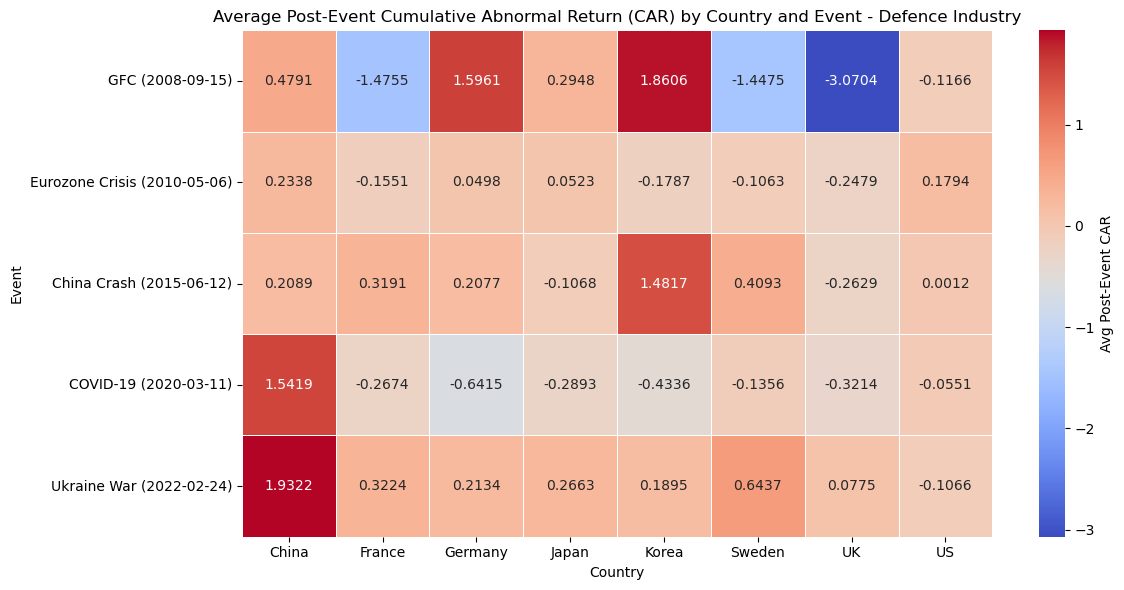

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

event_label_map = {
    '2008-09-15': 'GFC (2008-09-15)',
    '2010-05-06': 'Eurozone Crisis (2010-05-06)',
    '2015-06-12': 'China Crash (2015-06-12)',
    '2020-03-11': 'COVID-19 (2020-03-11)',
    '2022-02-24': 'Ukraine War (2022-02-24)'
}

# Filter for post-event data
post_event_data = all_returns[all_returns['post_event'] == 1].copy()

#Filter for Defence Industry Data only
post_event_data = post_event_data[~post_event_data['ticker'].isin(market_index_tickers)]

# Map tickers to countries
post_event_data['country'] = post_event_data['ticker'].apply(get_country_from_ticker)

# Group by event and country to get average CAR
heatmap_data = post_event_data.groupby(['event', 'country'])['CAR'].mean().unstack()

# Map event labels using your event_label_map
heatmap_data.index = heatmap_data.index.map(
    lambda e: event_label_map.get(pd.to_datetime(e).strftime('%Y-%m-%d'), str(e))
)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data, annot=True, fmt=".4f", cmap="coolwarm",
    linewidths=0.5, cbar_kws={'label': 'Avg Post-Event CAR'}
)

plt.title('Average Post-Event Cumulative Abnormal Return (CAR) by Country and Event - Defence Industry')
plt.xlabel('Country')
plt.ylabel('Event')
plt.tight_layout()
plt.show()

HEATMAP OF AVERAGE PRE-EVENT CAR'S (DEFENCE INDUSTRY)

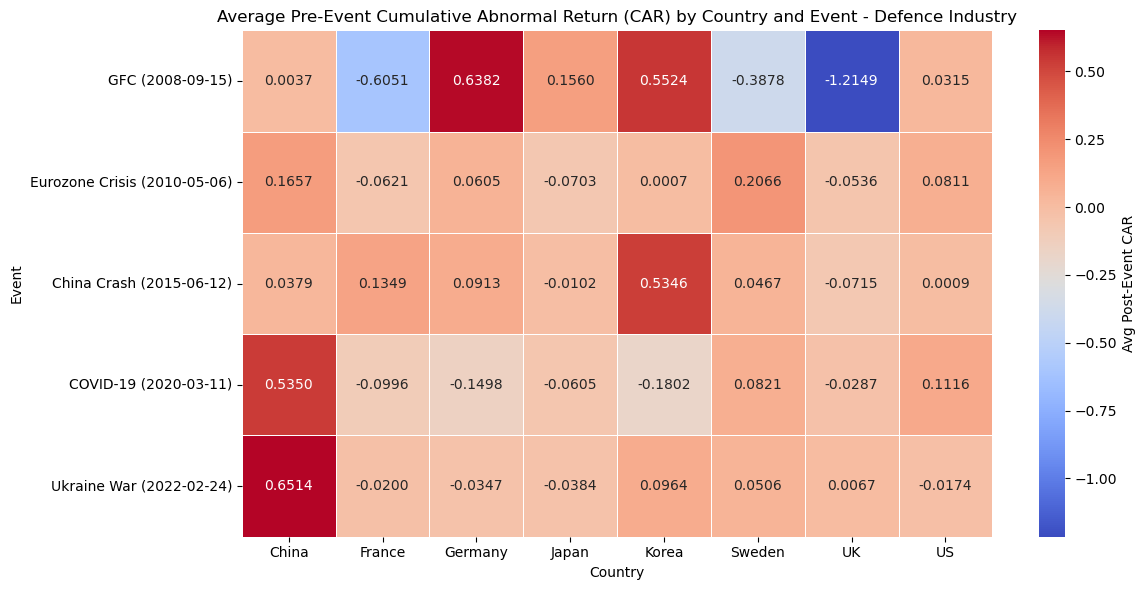

In [45]:
# Filter for post-event data
pre_event_data = all_returns[all_returns['post_event'] == 0].copy()

#Filter for Defence Industry Data only
pre_event_data = pre_event_data[~pre_event_data['ticker'].isin(market_index_tickers)]

# Map tickers to countries
pre_event_data['country'] = pre_event_data['ticker'].apply(get_country_from_ticker)

# Group by event and country to get average CAR
heatmap_data = pre_event_data.groupby(['event', 'country'])['CAR'].mean().unstack()

# Map event labels using your event_label_map
heatmap_data.index = heatmap_data.index.map(
    lambda e: event_label_map.get(pd.to_datetime(e).strftime('%Y-%m-%d'), str(e))
)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data, annot=True, fmt=".4f", cmap="coolwarm",
    linewidths=0.5, cbar_kws={'label': 'Avg Post-Event CAR'}
)

plt.title('Average Pre-Event Cumulative Abnormal Return (CAR) by Country and Event - Defence Industry')
plt.xlabel('Country')
plt.ylabel('Event')
plt.tight_layout()
plt.show()

Pre-Post Excess by Event

In [47]:
# Market (country-level)
idx_df = all_returns[all_returns['ticker'].isin(market_index_tickers)].copy()
idx_df['Country'] = idx_df['ticker'].apply(get_country_from_ticker)
mkt_pp = (idx_df.groupby(["event","Country","post_event"])["excess_return"]
               .mean()
               .unstack("post_event"))  # columns: 0 (pre), 1 (post)
mkt_pp = mkt_pp.rename(columns={0:"pre",1:"post"})
mkt_pp["mkt_excess_shift"] = mkt_pp["post"] - mkt_pp["pre"]
mkt_pp = mkt_pp[["mkt_excess_shift"]].reset_index()

# Firms
def_df = all_returns[~all_returns['ticker'].isin(market_index_tickers)].copy()
def_df['Country'] = def_df['ticker'].apply(get_country_from_ticker)
firm_pp = (def_df.groupby(["event","Country","ticker","post_event"])["excess_return"]
                 .mean()
                 .unstack("post_event"))  # columns: 0 (pre), 1 (post)
firm_pp = firm_pp.rename(columns={0:"pre",1:"post"})
# keep only firms with both windows
firm_pp = firm_pp.dropna(subset=["pre","post"])
firm_pp["firm_excess_shift"] = firm_pp["post"] - firm_pp["pre"]
firm_pp = firm_pp[["firm_excess_shift"]].reset_index()

# Merge: attach each firm's country-level market shift for the same event
scatter_df = pd.merge(firm_pp, mkt_pp, on=["event","Country"], how="left")

# ---------- plot: one figure per event ----------
outdir = ensure_dir("./figures_s1c_event")
events = sorted(scatter_df["event"].astype(str).unique().tolist())

saved = 0
for ev in events:
    sub = scatter_df[scatter_df["event"] == ev].dropna(subset=["mkt_excess_shift","firm_excess_shift"])
    if sub.empty:
        continue

    x = sub["mkt_excess_shift"].values
    y = sub["firm_excess_shift"].values

    fig, ax = plt.subplots(figsize=(8,6))  # one chart per figure

    ax.scatter(x, y, s=25)  # default style, no custom colours

    # 45° line and axes at 0
    lo = np.nanmin([x.min(), y.min()])
    hi = np.nanmax([x.max(), y.max()])
    pad = 0.05 * (hi - lo if hi > lo else 1.0)
    lo, hi = lo - pad, hi + pad
    ax.plot([lo, hi], [lo, hi])  # 45° line
    ax.axhline(0, linewidth=1)
    ax.axvline(0, linewidth=1)

    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    ax.set_xlabel("Market post–pre Excess (country-level)")
    ax.set_ylabel("Firm post–pre Excess")
    ax.set_title(f"Post–pre Excess: firm vs country market\nEvent: {ev}")

    fig.tight_layout()
    outpath = outdir / f"Figure_S1-C_Event_{sanitize(ev)}.png"
    fig.savefig(outpath, dpi=200, bbox_inches="tight")
    plt.close(fig)
    saved += 1

print(f"Saved {saved} figures to {outdir.resolve()}")

Saved 5 figures to C:\Users\pauln\University Python\Dissertation\figures_s1c_event


Mean Actual Return of Defence Firms Before and After Event (by Country)

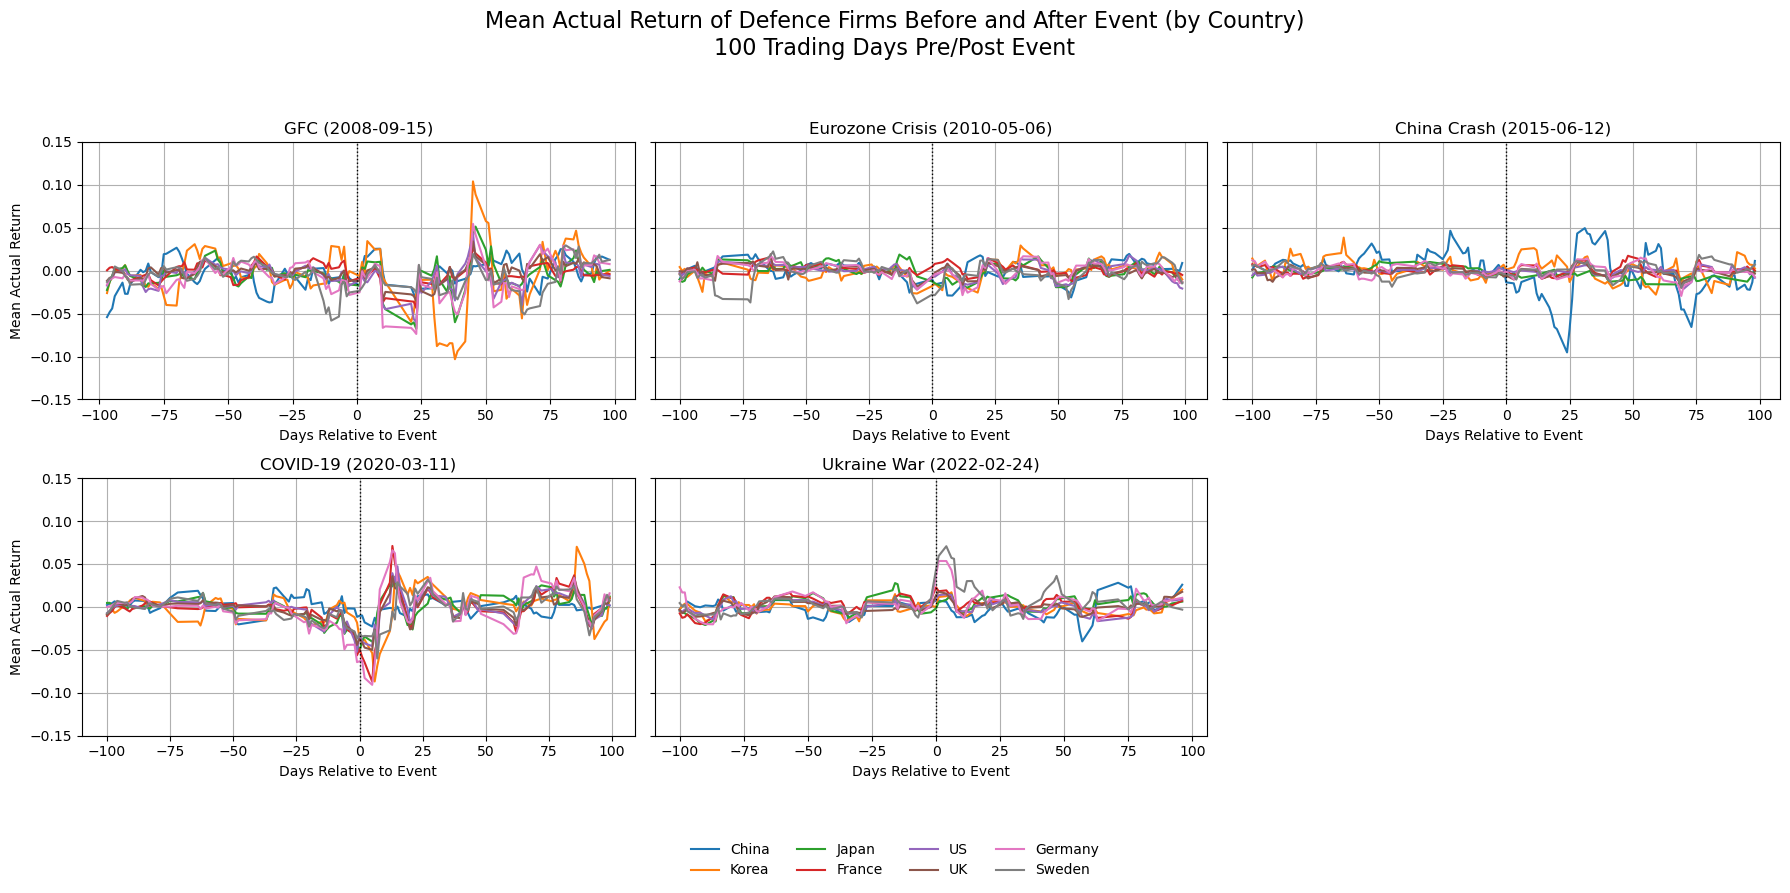

In [49]:
# Make sure both are datetime
all_returns['event'] = pd.to_datetime(all_returns['event'])

# Calculate day_relative as days between row date and event date
all_returns['day_relative'] = (all_returns['date'] - all_returns['event']).dt.days

#Filter for Defence Industry Data only, sort by country, and for days before and after each event
window = 100
filtered_returns = all_returns[~all_returns['ticker'].isin(market_index_tickers)].copy()
filtered_returns['country'] = filtered_returns['ticker'].apply(get_country_from_ticker)
filtered_returns = filtered_returns[(filtered_returns['day_relative'] >= -window) & (filtered_returns['day_relative'] <= window)]

# AGGREGATE: Mean actual return by country, event, and day_relative 
mean_returns = (
    filtered_returns
    .groupby(['event', 'country', 'day_relative'])['actual_return']
    .mean()
    .reset_index()
)

# SETUP PLOTTING
events = filtered_returns['event'].unique()
countries = filtered_returns['country'].unique()
palette = sns.color_palette("tab10", len(countries))

n_events = len(events)
n_cols = 3
n_rows = (n_events + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows), sharey=True)
axes = axes.flatten()

for i, event in enumerate(events):
    ax = axes[i]
    event_str = pd.to_datetime(str(event)).strftime('%Y-%m-%d')
    title = event_label_map.get(event_str, str(event))
    for j, country in enumerate(countries):
        data = mean_returns[
            (mean_returns['event'] == event) &
            (mean_returns['country'] == country)
        ].sort_values('day_relative')
        if not data.empty:
            # smooth the line for clarity
            data['smooth'] = data['actual_return'].rolling(window=5, min_periods=1, center=True).mean()
            ax.plot(data['day_relative'], data['smooth'], label=country, color=palette[j])
    ax.axvline(0, color='black', linestyle=':', lw=1)
    ax.set_title(title)
    ax.set_xlabel("Days Relative to Event")
    if i % n_cols == 0:
        ax.set_ylabel("Mean Actual Return")
    ax.set_ylim(-0.15, 0.15)
    ax.grid(True)

# Remove empty subplot(s)
for ax in axes[len(events):]:
    ax.axis('off')

# Legend below all plots
fig.legend(countries, loc='lower center', ncol=4, frameon=False, bbox_to_anchor=(0.5, -0.08))
fig.suptitle("Mean Actual Return of Defence Firms Before and After Event (by Country)\n100 Trading Days Pre/Post Event", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0.04, 1, 0.98])
plt.show()

INDIVIDUAL PLOTS

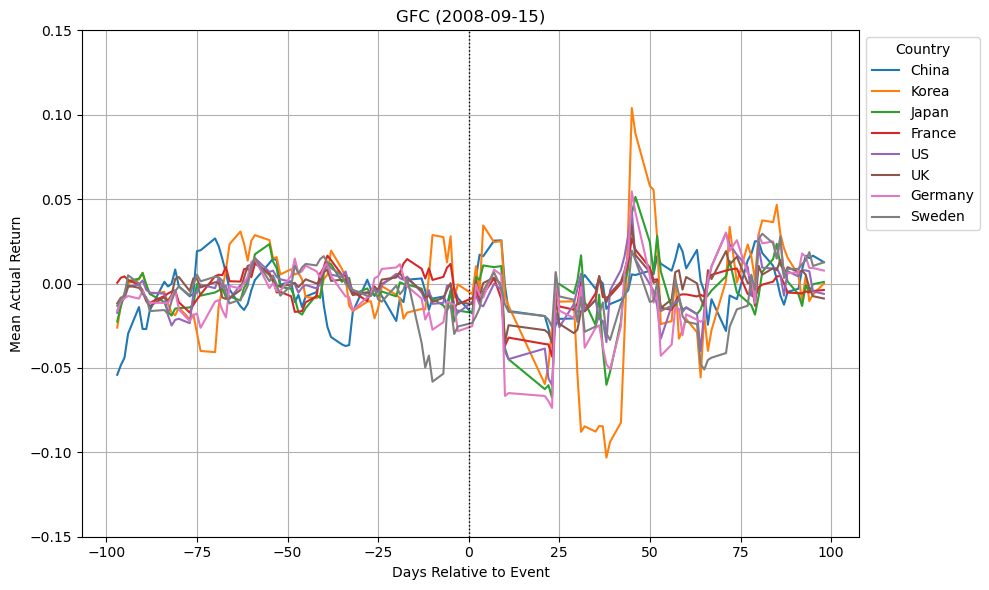

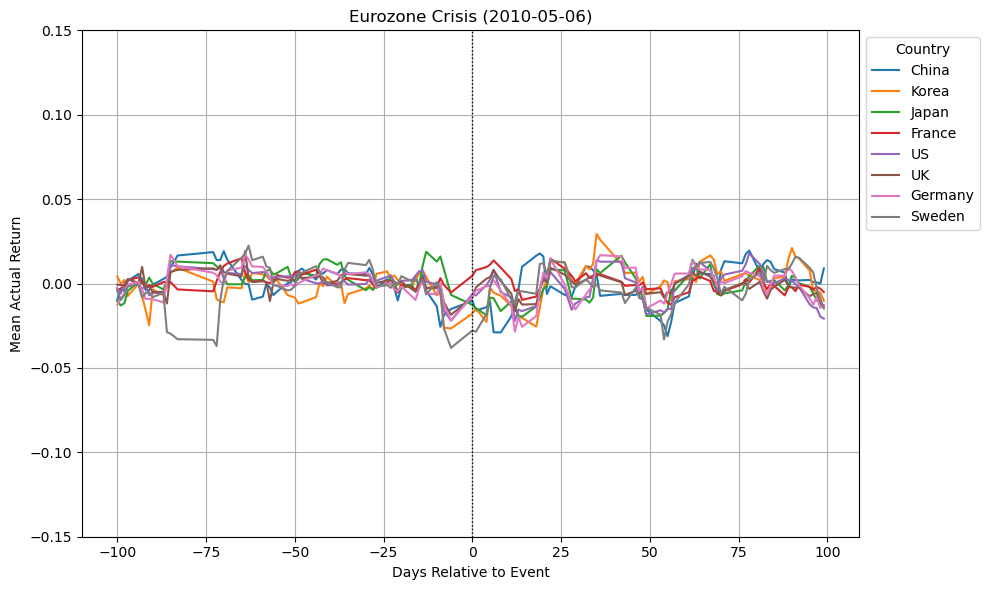

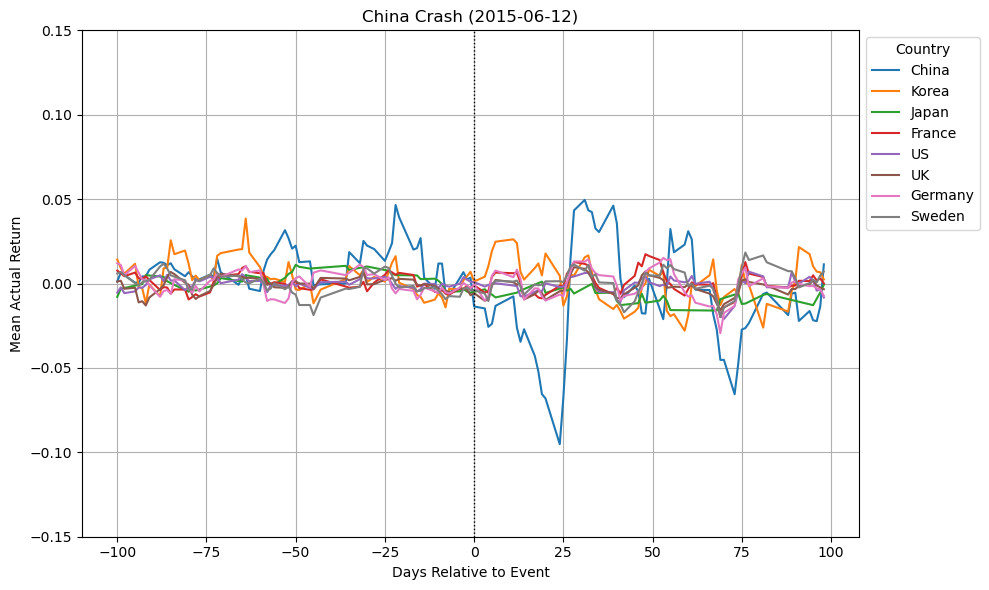

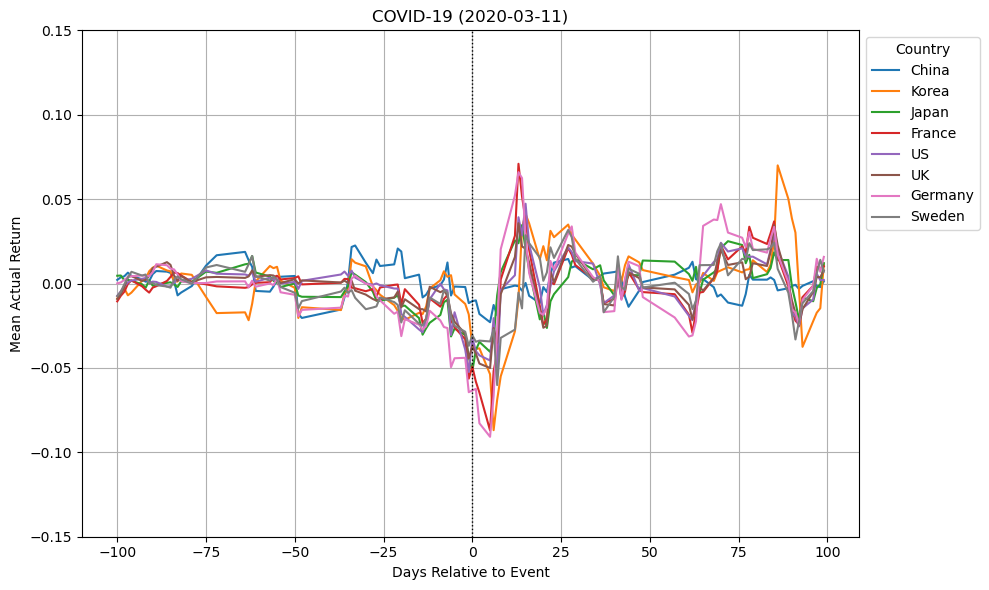

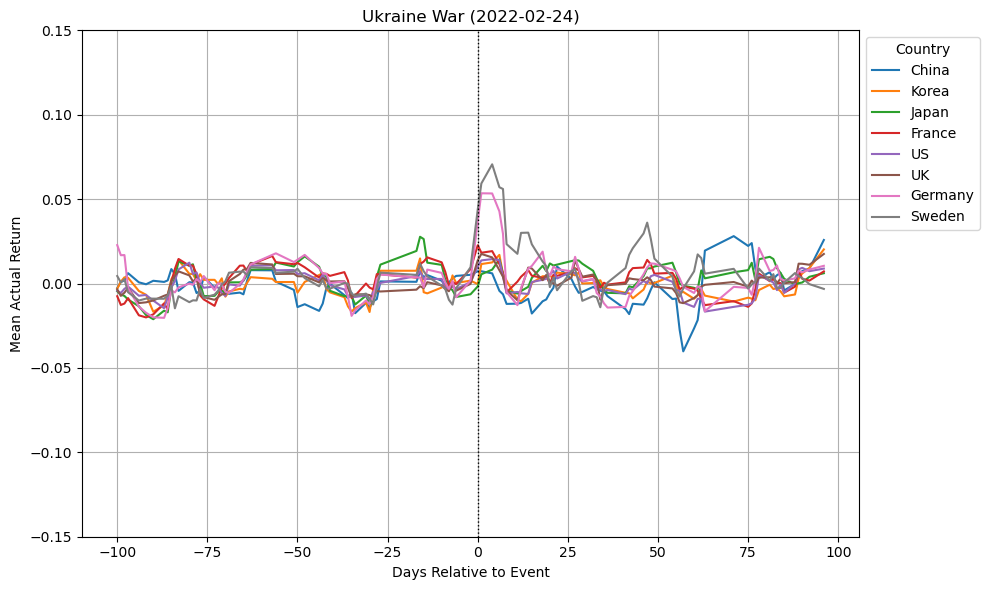

In [51]:
window = 100
mean_returns = (
    filtered_returns
    .groupby(['event', 'country', 'day_relative'])['actual_return']
    .mean()
    .reset_index()
)

events = filtered_returns['event'].unique()
countries = filtered_returns['country'].unique()
palette = sns.color_palette("tab10", len(countries))

for event in events:
    plt.figure(figsize=(10, 6))
    event_str = pd.to_datetime(str(event)).strftime('%Y-%m-%d')
    title = event_label_map.get(event_str, str(event))
    for j, country in enumerate(countries):
        data = mean_returns[
            (mean_returns['event'] == event) &
            (mean_returns['country'] == country)
        ].sort_values('day_relative')
        if not data.empty:
            data['smooth'] = data['actual_return'].rolling(window=5, min_periods=1, center=True).mean()
            plt.plot(data['day_relative'], data['smooth'], label=country, color=palette[j])
    plt.axvline(0, color='black', linestyle=':', lw=1)
    plt.title(title)
    plt.xlabel("Days Relative to Event")
    plt.ylabel("Mean Actual Return")
    plt.ylim(-0.15, 0.15)
    plt.grid(True)
    plt.legend(title='Country', loc='upper left', bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()

Significance Map for T-Test Results

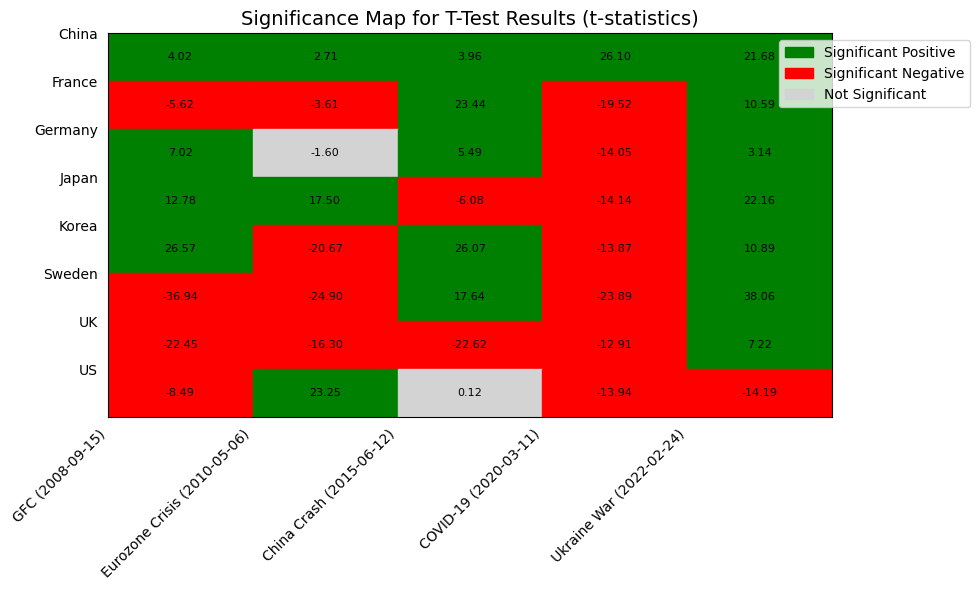

In [53]:
import matplotlib.patches as mpatches

# Classify significance for color coding
def classify_significance(row):
    if row['p-value'] < 0.05:
        if row['t-statistic'] > 0:
            return 'Significant Positive'
        elif row['t-statistic'] < 0:
            return 'Significant Negative'
    return 'Not Significant'

t_test_df['Significance Category'] = t_test_df.apply(classify_significance, axis=1)

# Color map
color_map = {
    'Significant Positive': 'green',
    'Significant Negative': 'red',
    'Not Significant': 'lightgrey'
}

# Create pivot tables
pivot_colors = t_test_df.pivot(index='Country', columns='Event', values='Significance Category')
pivot_tvals = t_test_df.pivot(index='Country', columns='Event', values='t-statistic')

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Draw colored rectangles
for y, country in enumerate(pivot_colors.index):
    for x, event in enumerate(pivot_colors.columns):
        color = color_map.get(pivot_colors.loc[country, event], 'white')
        ax.add_patch(plt.Rectangle((x, y), 1, 1, color=color))

# Add t-stat text in cells
for y, country in enumerate(pivot_tvals.index):
    for x, event in enumerate(pivot_tvals.columns):
        t_val = pivot_tvals.loc[country, event]
        if pd.notnull(t_val):
            ax.text(x + 0.5, y + 0.5, f"{t_val:.2f}",  # 2 decimal places
                    ha='center', va='center', fontsize=8, color='black')

# Formatting
# Apply mapping to x-axis labels
event_labels = [event_label_map.get(str(e), str(e)) for e in pivot_colors.columns]
ax.set_xticks(range(len(pivot_colors.columns)))
ax.set_xticklabels(event_labels, rotation=45, ha='right')
ax.set_yticks(range(len(pivot_colors.index)))
ax.set_yticklabels(pivot_colors.index)
ax.set_xlim(0, len(pivot_colors.columns))
ax.set_ylim(0, len(pivot_colors.index))
ax.invert_yaxis()

# Remove ticks
ax.tick_params(bottom=False, left=False)

# Title
ax.set_title('Significance Map for T-Test Results (t-statistics)', fontsize=14)

# Legend
legend_patches = [
    mpatches.Patch(color='green', label='Significant Positive'),
    mpatches.Patch(color='red', label='Significant Negative'),
    mpatches.Patch(color='lightgrey', label='Not Significant')
]
ax.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.2, 1))

plt.tight_layout()
plt.show()

Top and Bottom 5 Firm CARs - Pre vs Post Event

In [55]:
ticker_to_name = {
    'BA.L': 'BAE Systems',
    'RYCEY': 'Rolls-Royce Holdings',
    'BAB.L': 'Babcock International',
    'SRP.L': 'Serco Group',
    'CHG.L': 'Chemring Group',
    'QQ.L': 'QinetiQ Group',
    '^FTSE': 'FTSE 100 Index',
    'RHM.DE': 'Rheinmetall AG',
    'TKA.DE': 'Thyssenkrupp AG',
    '^GDAXI': 'DAX Index',
    'SAAB-B.ST': 'Saab AB',
    'EWD': 'iShares MSCI Sweden ETF',
    'HO.PA': 'Thales Group',
    'SAF.PA': 'Safran SA',
    'AM.PA': 'Dassault',
    '^FCHI': 'CAC 40 Index',
    'BA': 'Boeing',
    'RTX': 'Raytheon Technologies',
    'LMT': 'Lockheed Martin',
    'NOC': 'Northrop Grumman',
    'GD': 'General Dynamics',
    'LHX': 'L3Harris Technologies',
    'HON': 'Honeywell',
    'CACI': 'CACI International',
    'GE': 'General Electric',
    'TXT': 'Textron',
    'TDY': 'Teledyne Technologies',
    'OSK': 'Oshkosh Corporation',
    'ETN': 'Eaton Corporation',
    'CW': 'Curtiss-Wright',
    '^GSPC': 'S&P 500 Index',
    '000880.KS': 'Hanwha Aerospace',
    '^KS11': 'KOSPI Index',
    '7011.T': 'Mitsubishi Heavy Industries',
    '7013.T': 'IHI Corporation',
    '6701.T': 'NEC Corporation',
    '^N225': 'Nikkei 225 Index',
    '000768.SZ': 'AVIC Xi’an Aircraft',
    '600879.SS': 'China Aerospace Times Electronics',
    '000065.SZ': 'Norinco',
    '600118.SS': 'China Spacesat',
    '600850.SS': 'CETC Digital Technology',
    '600150.SS': 'China CSSC',
    '600893.SS': 'AECC Aviation Power',
    '000001.SS': 'SSE Composite Index'
}

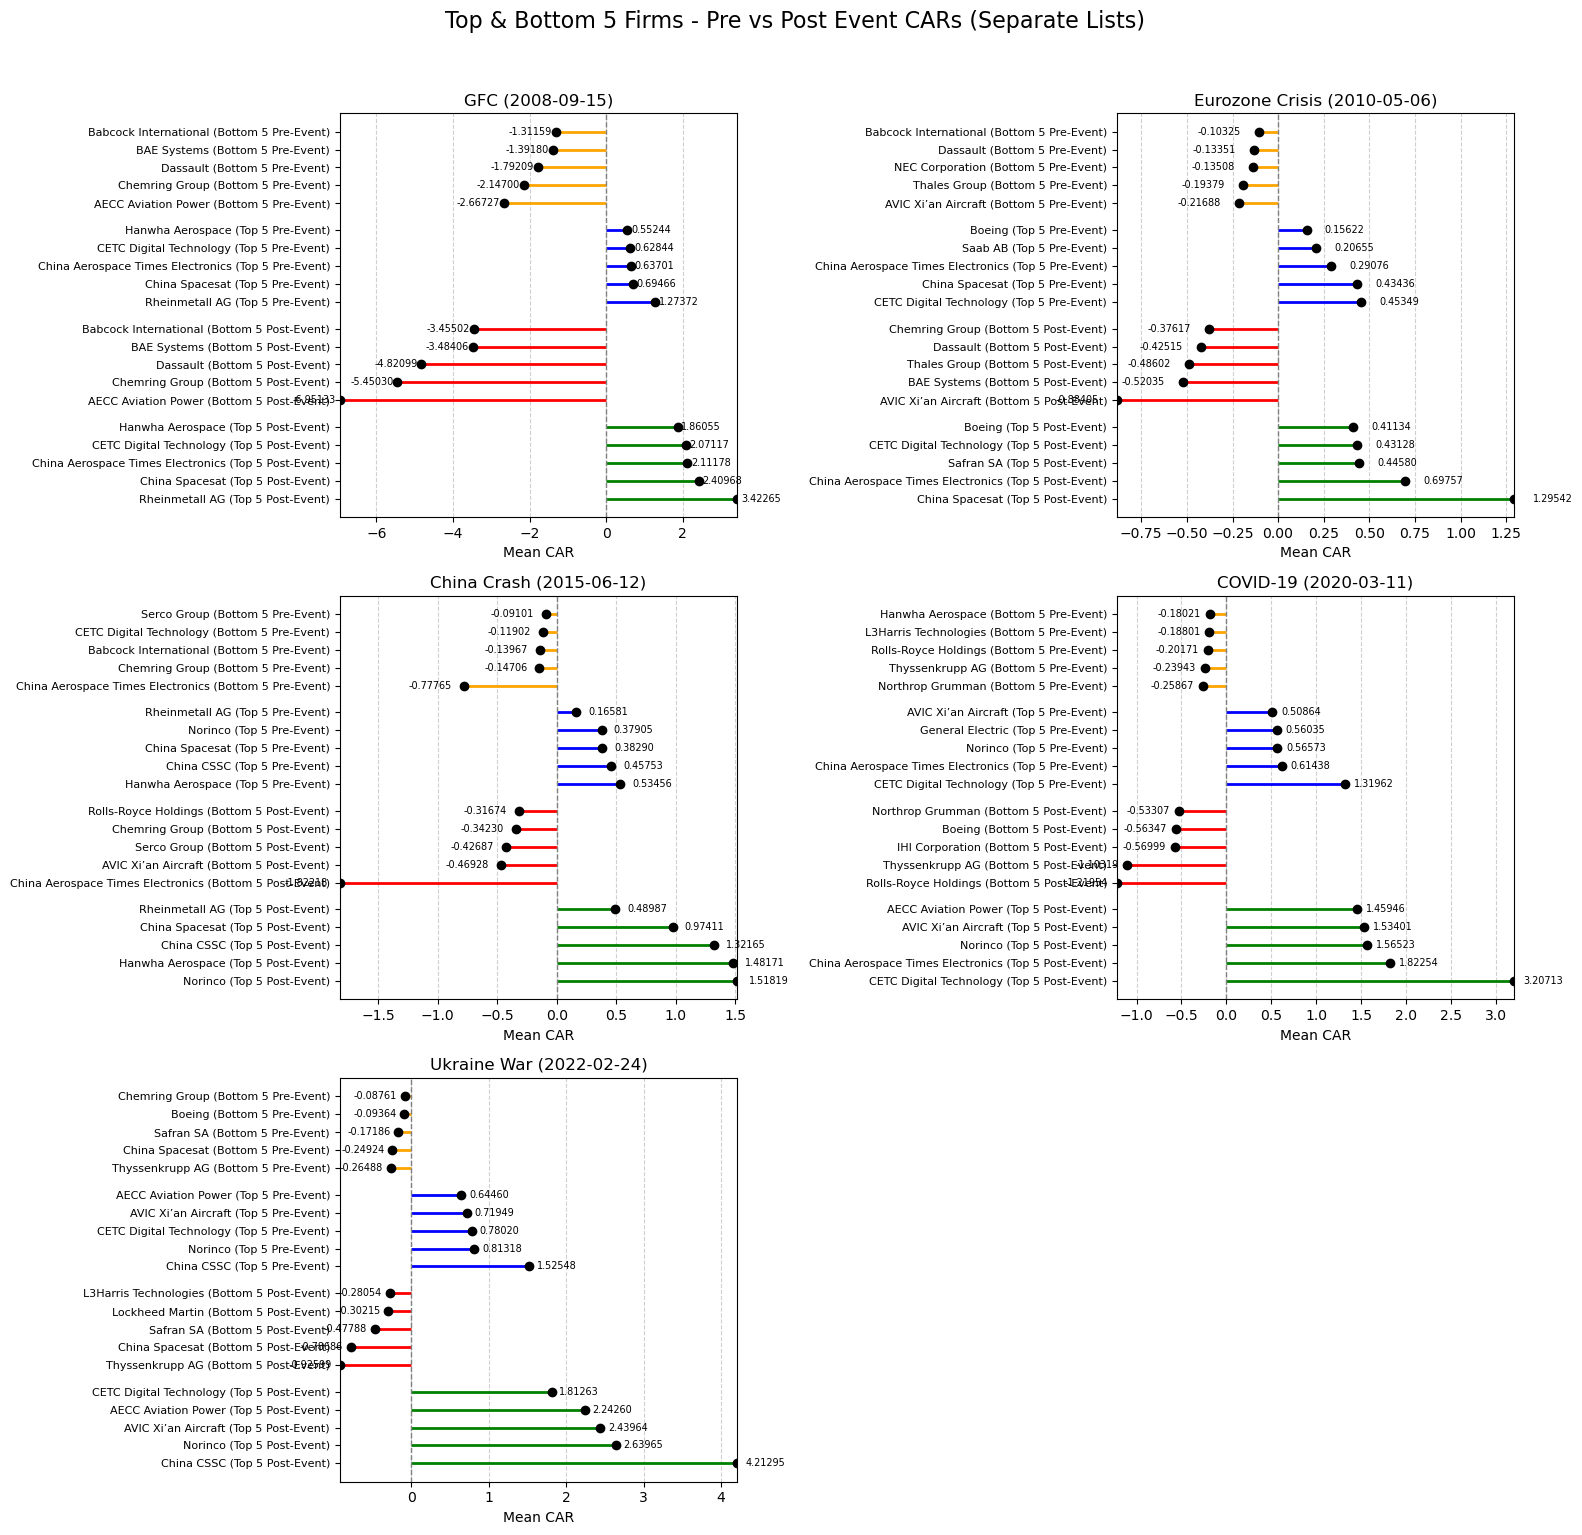

In [56]:
def plot_top_bottom_pre_post_separate(data):
    events = data['event'].unique()
    n_events = len(events)

    # Subplot layout (2 columns)
    n_cols = 2
    n_rows = int(np.ceil(n_events / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))
    axes = axes.flatten()

    for i, event in enumerate(events):
        event_data = data[data['event'] == event]

        # Mean CAR per firm for pre and post
        mean_cars = event_data.groupby(['ticker', 'post_event'])['CAR'].mean().reset_index()

        pre_cars = mean_cars[mean_cars['post_event'] == 0].copy()
        post_cars = mean_cars[mean_cars['post_event'] == 1].copy()

        # Map company names
        pre_cars['Company'] = pre_cars['ticker'].map(ticker_to_name).fillna(pre_cars['ticker'])
        post_cars['Company'] = post_cars['ticker'].map(ticker_to_name).fillna(post_cars['ticker'])

        # Get top & bottom 5 for pre and post separately
        top5_pre = pre_cars.nlargest(5, 'CAR')
        bottom5_pre = pre_cars.nsmallest(5, 'CAR')
        top5_post = post_cars.nlargest(5, 'CAR')
        bottom5_post = post_cars.nsmallest(5, 'CAR')

        # Combine for plotting (each group separate)
        all_groups = [
            (top5_post, 'Top 5 Post-Event', 'green'),
            (bottom5_post, 'Bottom 5 Post-Event', 'red'),
            (top5_pre, 'Top 5 Pre-Event', 'blue'),
            (bottom5_pre, 'Bottom 5 Pre-Event', 'orange')
        ]

        ax = axes[i]
        y_pos = 0
        yticks = []
        ylabels = []
        offset = 0.1  # spacing between dot and label

        for group_df, label, color in all_groups:
            for _, row in group_df.iterrows():
                # Lollipop line
                ax.hlines(y=y_pos, xmin=0, xmax=row['CAR'], color=color, linewidth=2)
                ax.plot(row['CAR'], y_pos, 'o', color='black')

                # Label offset from dot
                ax.text(
                    row['CAR'] + offset if row['CAR'] >= 0 else row['CAR'] - offset,
                    y_pos,
                    f"{row['CAR']:.5f}",
                    va='center',
                    ha='left' if row['CAR'] >= 0 else 'right',
                    fontsize=7,
                    color='black'
                )

                # Track ticks
                yticks.append(y_pos)
                ylabels.append(f"{row['Company']} ({label})")
                y_pos += 1

            y_pos += 0.5  # blank space between groups

        # Formatting
        ax.axvline(0, color='grey', linestyle='--', linewidth=1)
        ax.set_yticks(yticks)
        ax.set_yticklabels(ylabels, fontsize=8)
        event_str = pd.to_datetime(event).strftime('%Y-%m-%d')
        ax.set_title(f"{event_label_map.get(event_str, event_str)}", fontsize=12)
        ax.set_xlabel("Mean CAR")
        ax.set_xlim(min(mean_cars['CAR'].min(), -0.1), max(mean_cars['CAR'].max(), 0.1))
        ax.grid(axis='x', linestyle='--', alpha=0.6)

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("Top & Bottom 5 Firms - Pre vs Post Event CARs (Separate Lists)", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Run
plot_top_bottom_pre_post_separate(all_returns)

Pre vs Post-Event Mean Excess Returns by Firm and (Market) Index

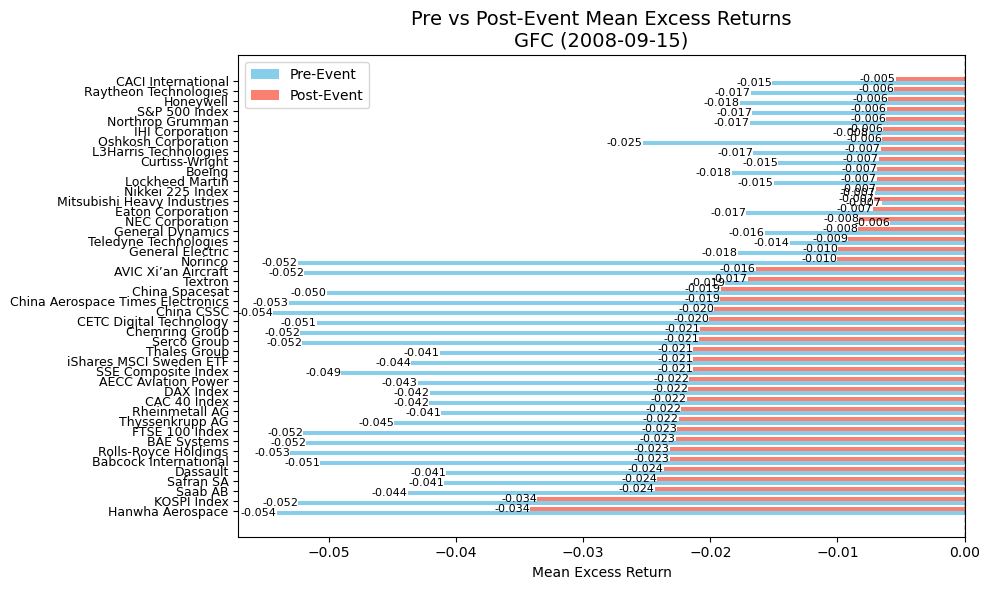

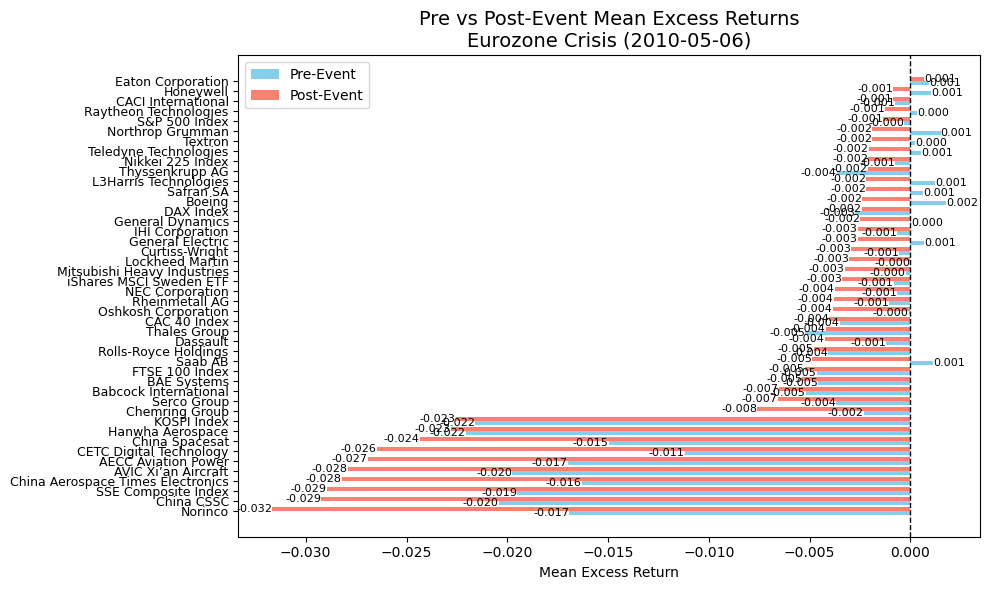

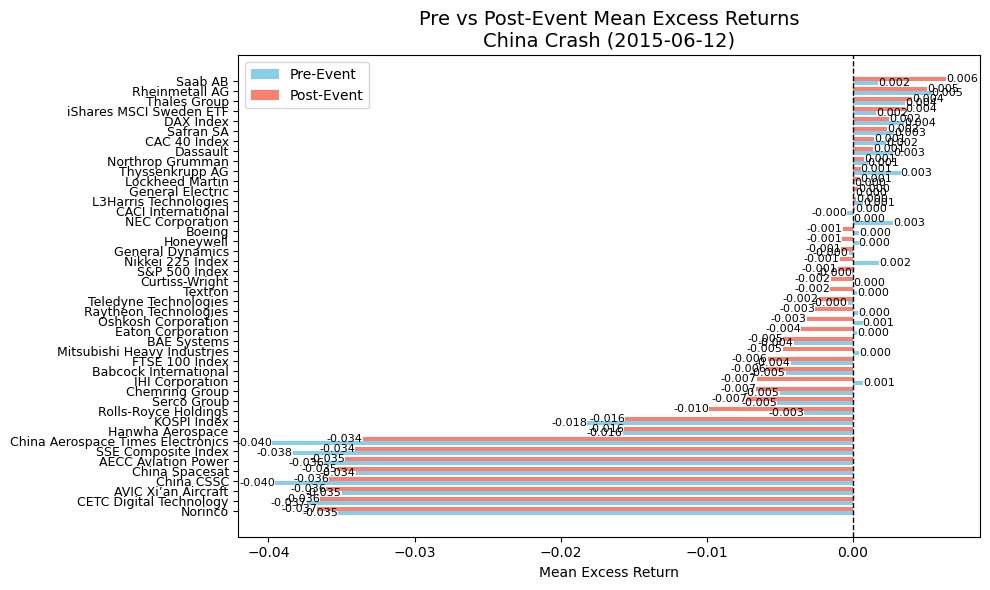

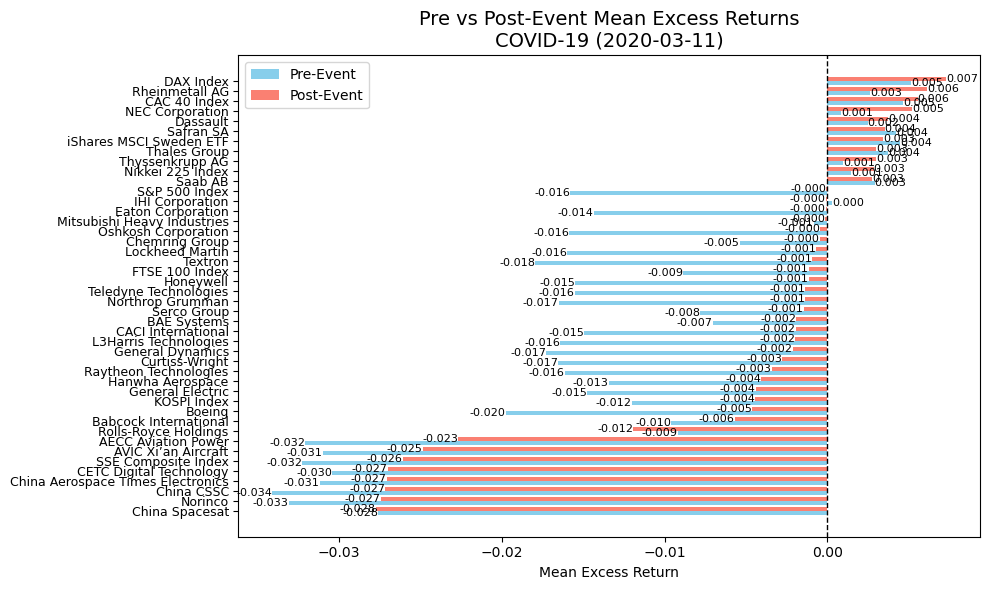

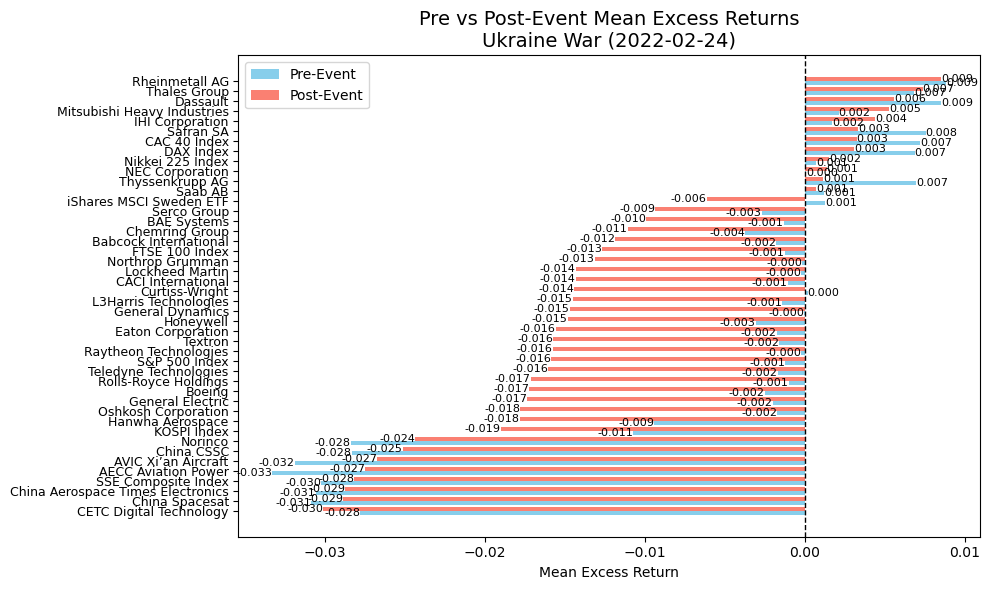

In [58]:
def plot_pre_post_excess_returns_bars_all(data, ticker_to_name, event_label_map):

    for event_date in sorted(data['event'].unique()):
        # Ensure we compare only the date part (YYYY-MM-DD)
        event_str = pd.to_datetime(event_date).strftime('%Y-%m-%d')
        event_label = event_label_map.get(event_str, event_str)

        df_event = data[data['event'] == event_date].copy()

        means = df_event.groupby(['ticker', 'post_event'])['excess_return'].mean().reset_index()
        means_pivot = means.pivot(index='ticker', columns='post_event', values='excess_return').reset_index()
        means_pivot.columns = ['ticker', 'Pre-Event', 'Post-Event']

        means_pivot['Company'] = means_pivot['ticker'].map(ticker_to_name).fillna(means_pivot['ticker'])
        means_pivot = means_pivot.sort_values('Post-Event')

        bar_width = 0.4
        y_pos = np.arange(len(means_pivot))

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.barh(y_pos - bar_width/2, means_pivot['Pre-Event'], height=bar_width, color='skyblue', label='Pre-Event')
        ax.barh(y_pos + bar_width/2, means_pivot['Post-Event'], height=bar_width, color='salmon', label='Post-Event')

        for i, v in enumerate(means_pivot['Pre-Event']):
            ax.text(v, i - bar_width/2, f"{v:.3f}", va='center', ha='left' if v >= 0 else 'right', fontsize=8)
        for i, v in enumerate(means_pivot['Post-Event']):
            ax.text(v, i + bar_width/2, f"{v:.3f}", va='center', ha='left' if v >= 0 else 'right', fontsize=8)

        ax.axvline(0, color='black', linestyle='--', linewidth=1)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(means_pivot['Company'], fontsize=9)
        ax.set_title(f"Pre vs Post-Event Mean Excess Returns\n{event_label}", fontsize=14)
        ax.set_xlabel("Mean Excess Return")
        ax.legend()
        plt.tight_layout()
        plt.show()

plot_pre_post_excess_returns_bars_all(all_returns, ticker_to_name, event_label_map)

Pre vs Post-Event Mean Actual Returns by Firm and (Market) Index

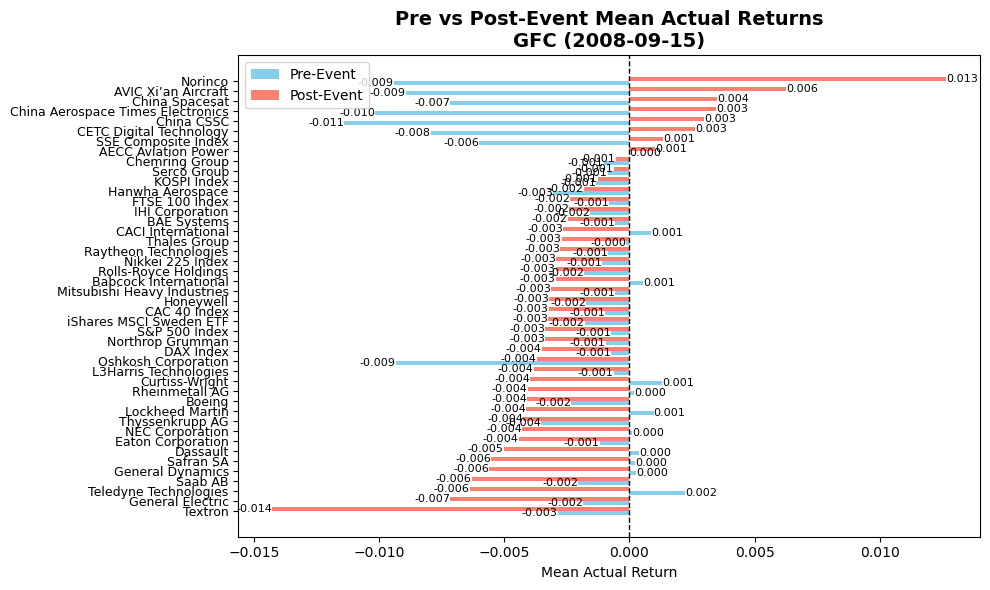

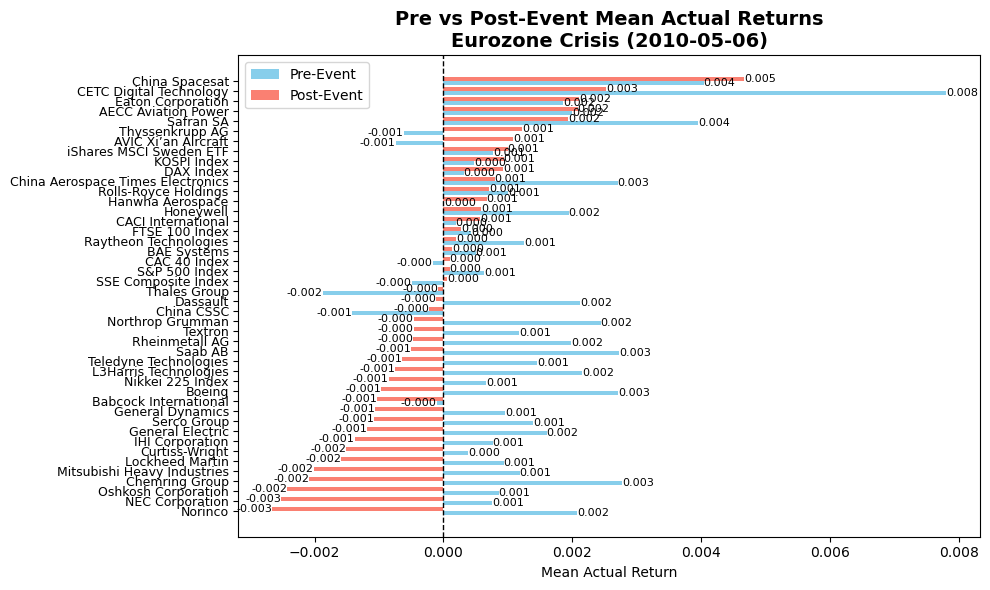

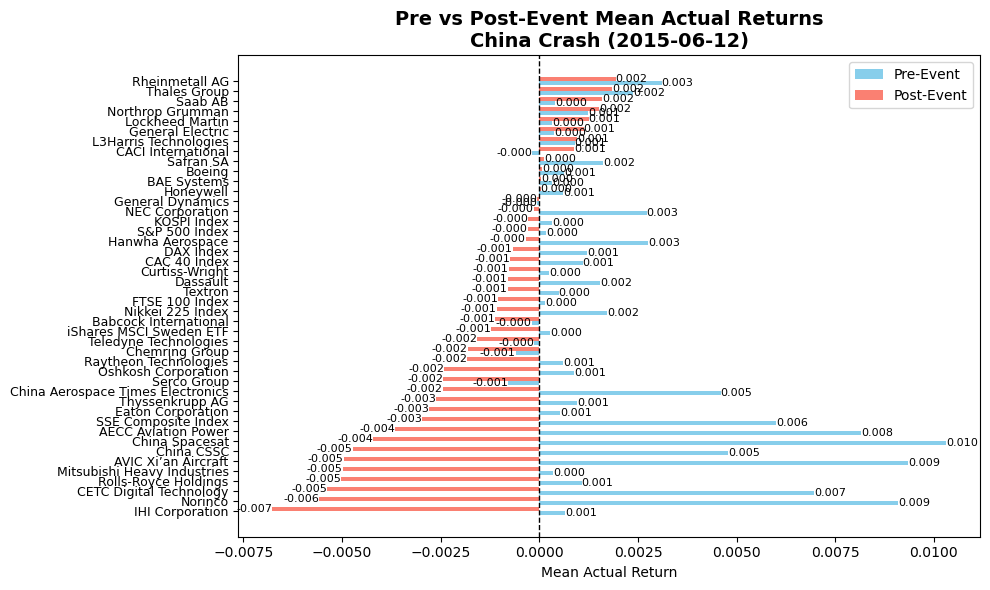

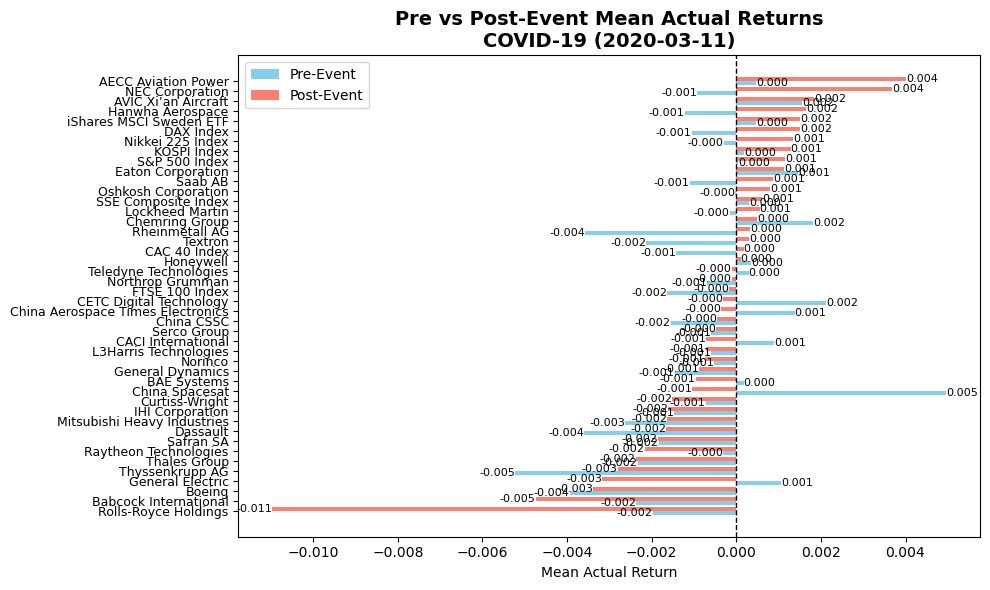

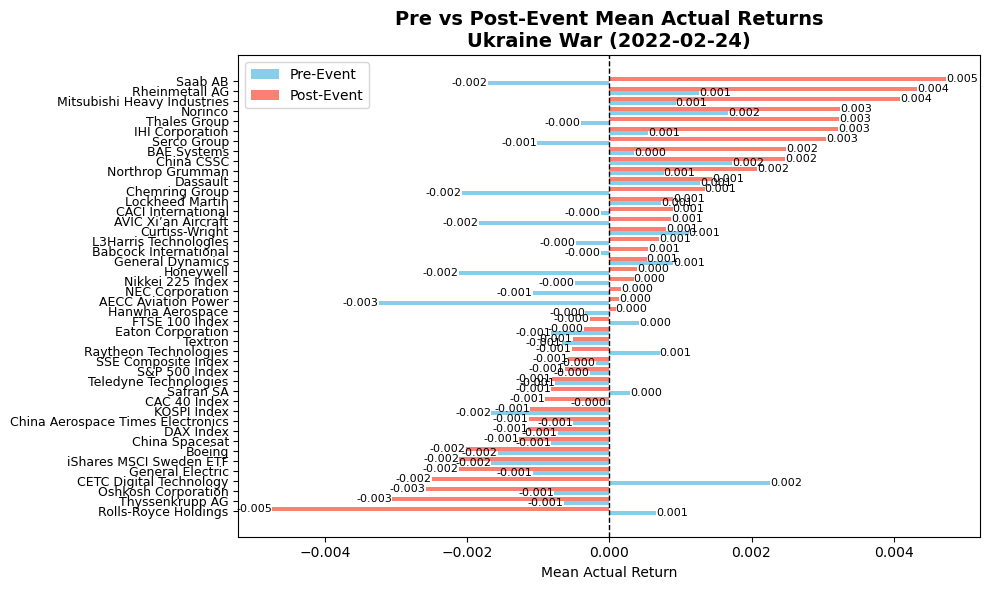

In [60]:
def plot_pre_post_actual_returns_bars_all(data, ticker_to_name, event_label_map):
    # Loop over all events
    for event_date in sorted(data['event'].unique()):
        # Filter to selected event
        df_event = data[data['event'] == event_date].copy()

        # Calculate mean actual returns pre and post
        means = df_event.groupby(['ticker', 'post_event'])['actual_return'].mean().reset_index()

        # Pivot to wide format
        means_pivot = means.pivot(index='ticker', columns='post_event', values='actual_return').reset_index()
        means_pivot.columns = ['ticker', 'Pre-Event', 'Post-Event']

        # Map tickers to company names
        means_pivot['Company'] = means_pivot['ticker'].map(ticker_to_name).fillna(means_pivot['ticker'])

        # Sort by post-event returns
        means_pivot = means_pivot.sort_values('Post-Event')

        # Set up bar positions
        bar_width = 0.4
        y_pos = np.arange(len(means_pivot))

        fig, ax = plt.subplots(figsize=(10, 6))

        # Pre-event bars
        ax.barh(y_pos - bar_width/2, means_pivot['Pre-Event'], height=bar_width, color='skyblue', label='Pre-Event')

        # Post-event bars
        ax.barh(y_pos + bar_width/2, means_pivot['Post-Event'], height=bar_width, color='salmon', label='Post-Event')

        # Add value labels
        for i, v in enumerate(means_pivot['Pre-Event']):
            ax.text(v, i - bar_width/2, f"{v:.3f}", va='center',
                    ha='left' if v >= 0 else 'right', fontsize=8)
        for i, v in enumerate(means_pivot['Post-Event']):
            ax.text(v, i + bar_width/2, f"{v:.3f}", va='center',
                    ha='left' if v >= 0 else 'right', fontsize=8)

        # Formatting
        ax.axvline(0, color='black', linestyle='--', linewidth=1)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(means_pivot['Company'], fontsize=9)

        # Event title with label mapping
        event_str = pd.to_datetime(event_date).strftime('%Y-%m-%d')
        event_label = event_label_map.get(event_str, event_str)
        ax.set_title(f"Pre vs Post-Event Mean Actual Returns\n{event_label}", fontsize=14, fontweight='bold')

        ax.set_xlabel("Mean Actual Return")
        ax.legend()
        plt.tight_layout()
        plt.show()

plot_pre_post_actual_returns_bars_all(all_returns, ticker_to_name, event_label_map)